# **Exploratory Analysis of Seasonal and Atmospheric Patterns on Mars**

## **1. Introduction**

### **Notebook Overview**
This exploratory phase focuses on understanding the structure, behavior, and quality of atmospheric data collected by the Curiosity rover at Gale Crater via the REMS instrument. Key goals include:

- Investigating trends, distributions, and seasonal cycles in temperature, pressure, UV radiation, and day length across multiple Martian years.
- Evaluating relationships between features and identifying possible anomalies or outliers.
- Validating temporal coverage and feature completeness to inform downstream forecasting and anomaly detection models.

This analysis ensures that the data is well-understood, reliable, and ready for modeling applications.

---

### **Dataset Description**
- **Dataset Source**: REMS data collected by the Curiosity Rover. It contains **3,197 records** spanning multiple Martian years, with variables covering **temperature, pressure, UV radiation, and day length**.
- **Key Columns**:
  - `Ls`: Solar longitude representing Mars’ position in its orbit.
  - `sunrise`, `sunset`: Times for sunrise and sunset. 
  - `max_ground_temp`, `min_ground_temp`: Ground temperature extremes.
  - `max_air_temp`, `min_air_temp`: Air temperature extremes.
  - `avg_air_temp`, `avg_ground_temp`: Average air and ground temperatures.
  - `mars_month`: Martian month based on solar longitude (30  degrees per month)
  - `mars_year`: Martian year based on mission start (Initial year = 1)
  - `mars_season`: Martian season based on solar longitude. Curiosity is located in the southern hemisphere which means our seasons are inverted.
  - `day_length`: Length of the Martian day in minutes.
  - `mean_pressue`: Average atmospheric pressure for a given day.
  - `UV_Radiation`: UV index categories.
- Purpose: This dataset helps study Martian weather patterns and seasonal variations.

---

### **Notes on Seasons**
Martian seasons function similarly to those on Earth. Each season corresponds to a particular solar longitudinal range which are outlined as follows:
| Solar Longitude (°) | Season (Southern Hemisphere) |
|---------------------|----------------------------|
| 0 to 89            | Autumn (Fall)              |
| 90 to 179          | Winter                     |
| 180 to 269         | Spring                     |
| 270 to 359         | Summer                     |

---

### **EDA Objectives**
- Understand feature relationships and trends.
- Investigate seasonal and cyclical trends for air and ground temperature, mean atmospheric pressure, and UV Radiation.
- Detect outliers and anomalies.

---

### **Key Questions to Explore**
- Are temperature and pressure correlated?
- How do seasonal and yearly trends affect Martian weather?
- What role does **day length** play in temperature variations?
- Are there **outliers or extreme events** in the dataset?

---

### **Importing Packages and Configuring Directory Pathing**

In [48]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.stderr = open(os.devnull, "w")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

from utils.utilities import decompose_adf, check_missing

import scipy
import scipy.stats as stats
from scipy.stats import levene
from scipy.stats import pearsonr, spearmanr, kendalltau
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
# Project directory configuration
DATA_PATH = '../data/'
PLOT_PATH = '../outputs/plots/'

---

## **2. Data Overview**

### **2.1 Load and Inspect Data**
The dataset was sourced from [Kaggle](https://www.kaggle.com/datasets/deepcontractor/mars-rover-environmental-monitoring-station/data). It was create by the user "DEEP CONTRACTOR" by deriving features from the public datasets provided by NASA and collected by the Curiosity Rover REMS instrumentation.

In [3]:
# Load the CSV file into a Pandas DataFrame
mars_df = pd.read_csv(os.path.join(DATA_PATH,'cleaned/mars_weather_cleaned.csv'), index_col='sol_number')
mars_df = mars_df.rename_axis("mars_day")

mars_df.head()

earth_date_time     Ls  mars_month  mars_year mars_season   sunrise  \
mars_day                                                                       
1             2012-08-07  150.0           6          1      winter  05:30:00   
9             2012-08-15  155.0           6          1      winter  05:28:00   
10            2012-08-16  155.0           6          1      winter  05:28:00   
11            2012-08-17  156.0           6          1      winter  05:28:00   
12            2012-08-18  156.0           6          1      winter  05:28:00   

            sunset  day_length  avg_ground_temp  max_ground_temp  \
mars_day                                                           
1         17:22:00       712.0            -45.5            -16.0   
9         17:22:00       714.0            -45.5            -16.0   
10        17:22:00       714.0            -45.5            -16.0   
11        17:21:00       713.0            -43.5            -11.0   
12        17:21:00       713.0            -47.0            -18.0   

          min_ground_temp  avg_air_temp  max_air_temp  min_air_temp  \
mars_day                                                              
1                   -75.0         -37.5           8.0         -83.0   
9                   -75.0         -37.5           8.0         -83.0   
10                  -75.0         -37.5           8.0         -83.0   
11                  -76.0         -37.0           9.0         -83.0   
12                  -76.0         -37.0           8.0         -82.0   

          mean_pressure  UV_Radiation  
mars_day                               
1                 739.0             4  
9                 739.0             4  
10                739.0             4  
11                740.0             4  
12                741.0             4

### **2.2 Summary Statistics**

In [4]:
mars_df.describe()

Ls   mars_month    mars_year   day_length  avg_ground_temp  \
count  3197.000000  3197.000000  3197.000000  3197.000000      3197.000000   
mean    166.959962     6.083203     3.507038   718.169221       -44.097279   
std     104.356771     3.466172     1.500218    12.036363         7.401663   
min       0.000000     1.000000     1.000000   702.000000       -72.500000   
25%      78.000000     3.000000     2.000000   707.000000       -50.500000   
50%     156.000000     6.000000     3.000000   716.000000       -43.000000   
75%     254.000000     9.000000     5.000000   730.000000       -37.500000   
max     359.000000    12.000000     6.000000   738.000000       -26.500000   

       max_ground_temp  min_ground_temp  avg_air_temp  max_air_temp  \
count      3197.000000      3197.000000   3197.000000   3197.000000   
mean        -13.182828       -75.011730    -39.147357      2.011730   
std          10.489177         5.529929      7.262277      9.398862   
min         -67.000000      -100.000000    -75.500000    -61.000000   
25%         -23.000000       -79.000000    -45.500000     -6.000000   
50%         -12.000000       -75.000000    -38.000000      3.000000   
75%          -4.000000       -71.000000    -33.000000     10.000000   
max          11.000000       -52.000000     -1.500000     24.000000   

       min_air_temp  mean_pressure  UV_Radiation  
count   3197.000000    3197.000000   3197.000000  
mean     -80.306537     828.997028      2.583359  
std        8.824723      57.224328      0.692132  
min     -136.000000     702.000000      1.000000  
25%      -86.000000     785.000000      2.000000  
50%      -80.000000     844.000000      3.000000  
75%      -75.000000     873.000000      3.000000  
max       -8.000000     925.000000      4.000000

In [5]:
check_missing(mars_df)

NaN Count  "Value not available" Count  \
earth_date_time          0                            0   
Ls                       0                            0   
mars_month               0                            0   
mars_year                0                            0   
mars_season              0                            0   
sunrise                  0                            0   
sunset                   0                            0   
day_length               0                            0   
avg_ground_temp          0                            0   
max_ground_temp          0                            0   
min_ground_temp          0                            0   
avg_air_temp             0                            0   
max_air_temp             0                            0   
min_air_temp             0                            0   
mean_pressure            0                            0   
UV_Radiation             0                            0   

                 Total % Missing or Unavailable  
earth_date_time                             0.0  
Ls                                          0.0  
mars_month                                  0.0  
mars_year                                   0.0  
mars_season                                 0.0  
sunrise                                     0.0  
sunset                                      0.0  
day_length                                  0.0  
avg_ground_temp                             0.0  
max_ground_temp                             0.0  
min_ground_temp                             0.0  
avg_air_temp                                0.0  
max_air_temp                                0.0  
min_air_temp                                0.0  
mean_pressure                               0.0  
UV_Radiation                                0.0

---

## **3. Temperature**

### **3.1 Air Temperature**

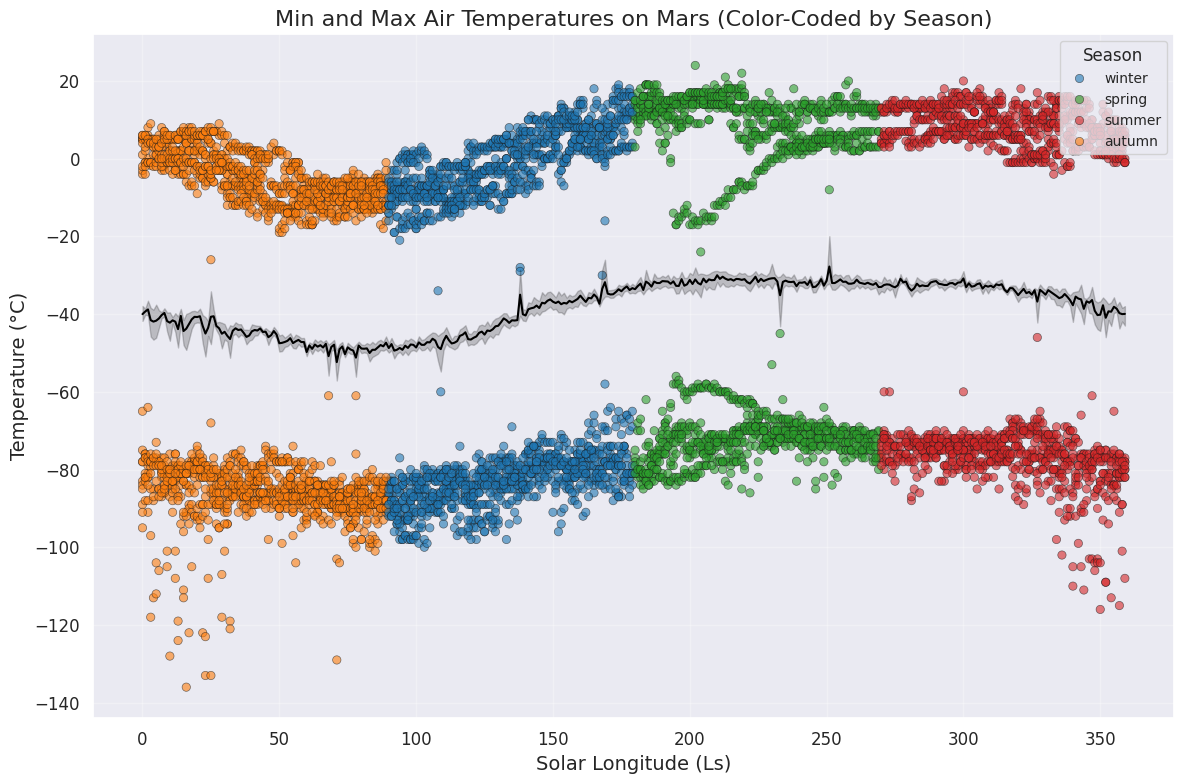

In [49]:
# Define a consistent color palette for the Martian seasons
season_palette = {
    "spring": "#2ca02c",  # Green
    "summer": "#d62728",   # Red
    "autumn": "#ff7f0e",  # Orange
    "winter": "#1f77b4"  # Blue
}

# Set up the figure
plt.figure(figsize=(12, 8))

# Scatter plot for min air temperature
sns.scatterplot(
    data=mars_df,
    x='Ls',
    y='min_air_temp',
    hue='mars_season',
    palette=season_palette,
    alpha=0.6,
    edgecolor='k'
)

# Scatter plot for max air temperature
sns.scatterplot(
    data=mars_df,
    x='Ls',
    y='max_air_temp',
    hue='mars_season',
    palette=season_palette,
    alpha=0.6,
    edgecolor='k'
)

# Line plot for average air temperatures
sns.lineplot(
    data=mars_df,
    x='Ls',
    y='avg_air_temp',
    color='black'
)

# Customize the plot
plt.title('Min and Max Air Temperatures on Mars (Color-Coded by Season)', fontsize=16)
plt.xlabel('Solar Longitude (Ls)', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)

# Fix the legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title='Season', fontsize=10, title_fontsize=12, loc='upper right')

plt.tight_layout()

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Min and Max Air Temperatures on Mars (Color-Coded by Season).png'))
plt.show()

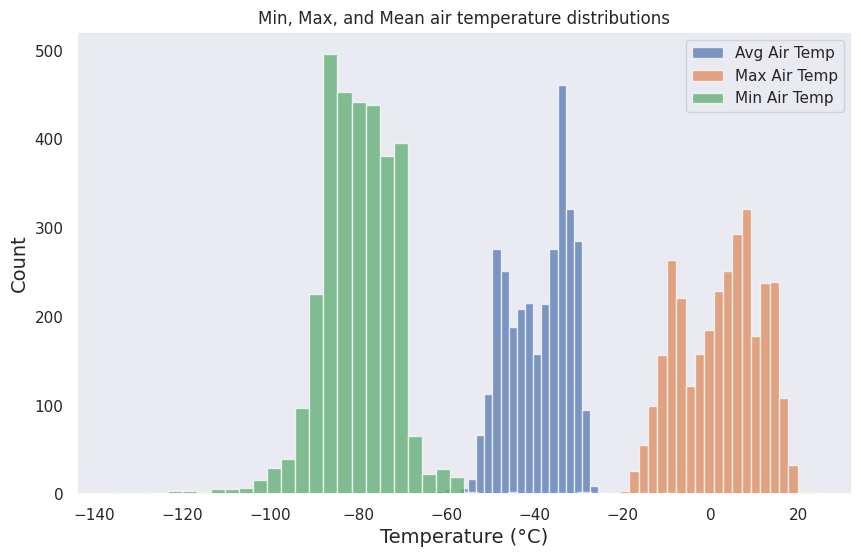

In [50]:
plt.figure(figsize=(10,6))
mars_df['avg_air_temp'].hist(bins=40, alpha=0.7, label='Avg Air Temp')
mars_df['max_air_temp'].hist(bins=40, alpha=0.7, label='Max Air Temp')
mars_df['min_air_temp'].hist(bins=40, alpha=0.7, label='Min Air Temp')
plt.grid(False)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Min, Max, and Mean air temperature distributions')
plt.legend()

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Min, Max, and Mean air temperature distributions.png'))
plt.show()

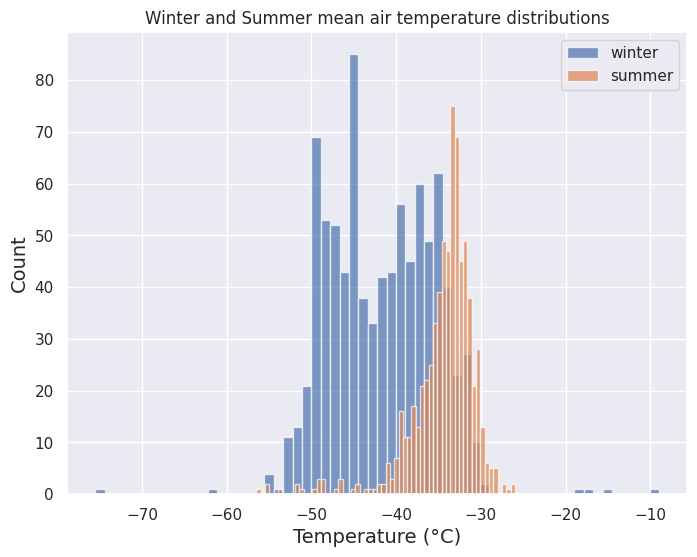

In [51]:
plt.figure(figsize=(8,6))
mars_df[mars_df['mars_season'] == 'winter']['avg_air_temp'].hist(bins=60, alpha=0.7, label='winter')
mars_df[mars_df['mars_season'] == 'summer']['avg_air_temp'].hist(bins=60, alpha=0.7, label='summer')
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Winter and Summer mean air temperature distributions')
plt.legend()

# Save the plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Winter and Summer mean air temperature distributions.png'))
plt.show()

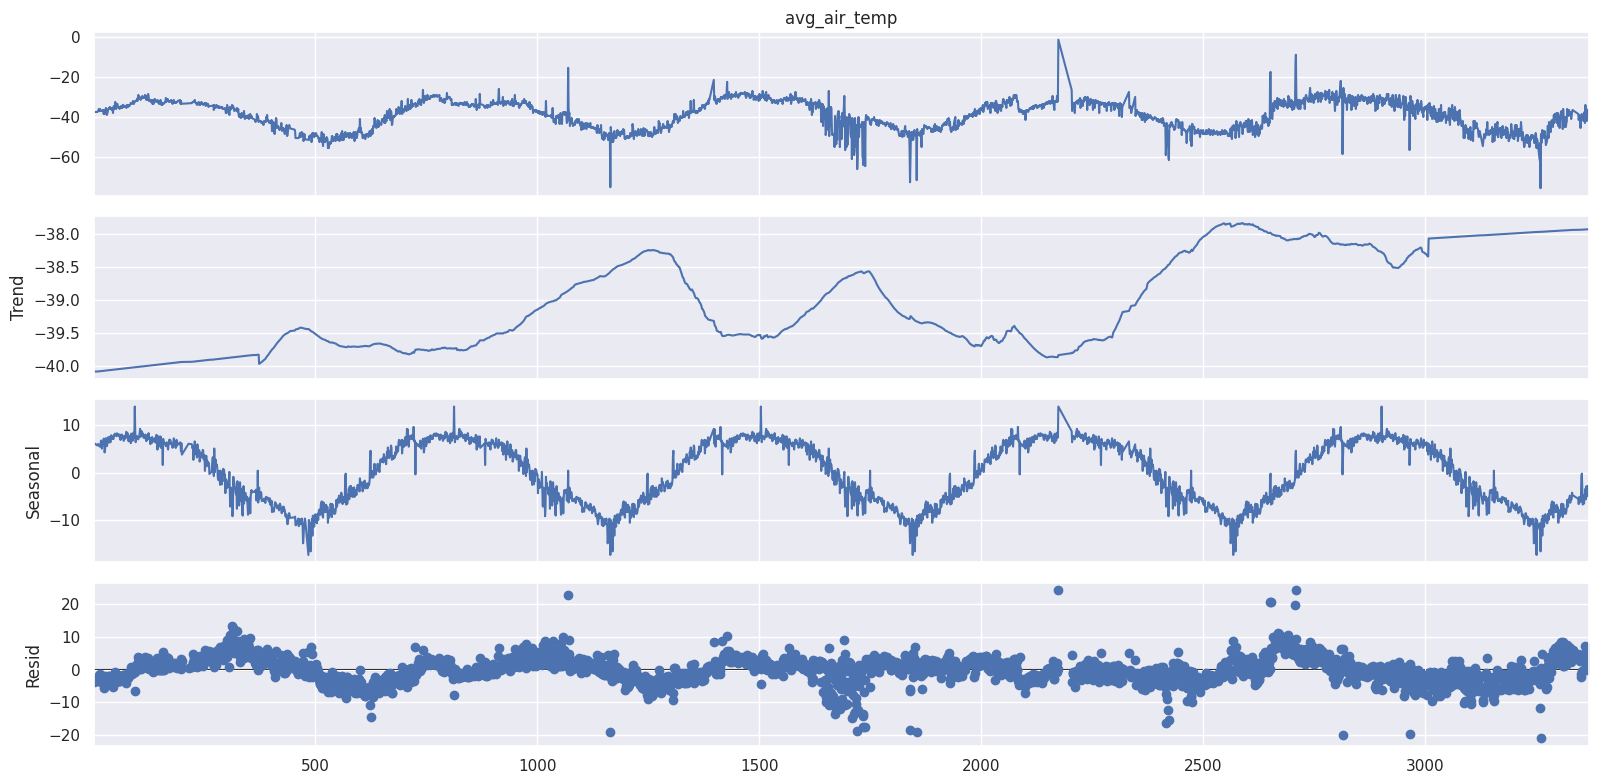

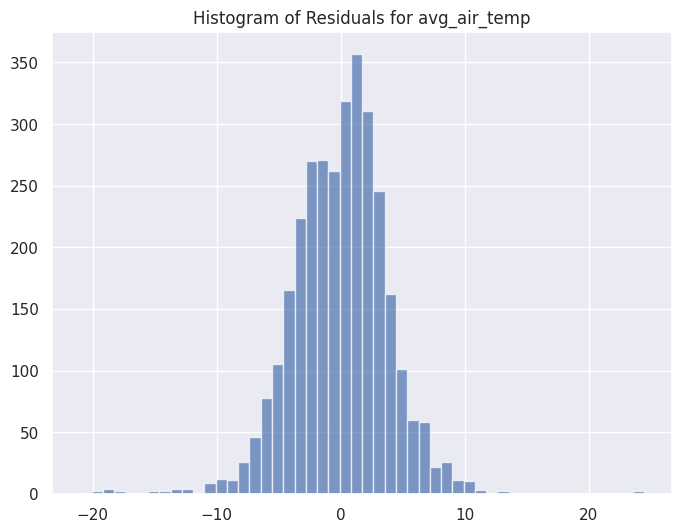

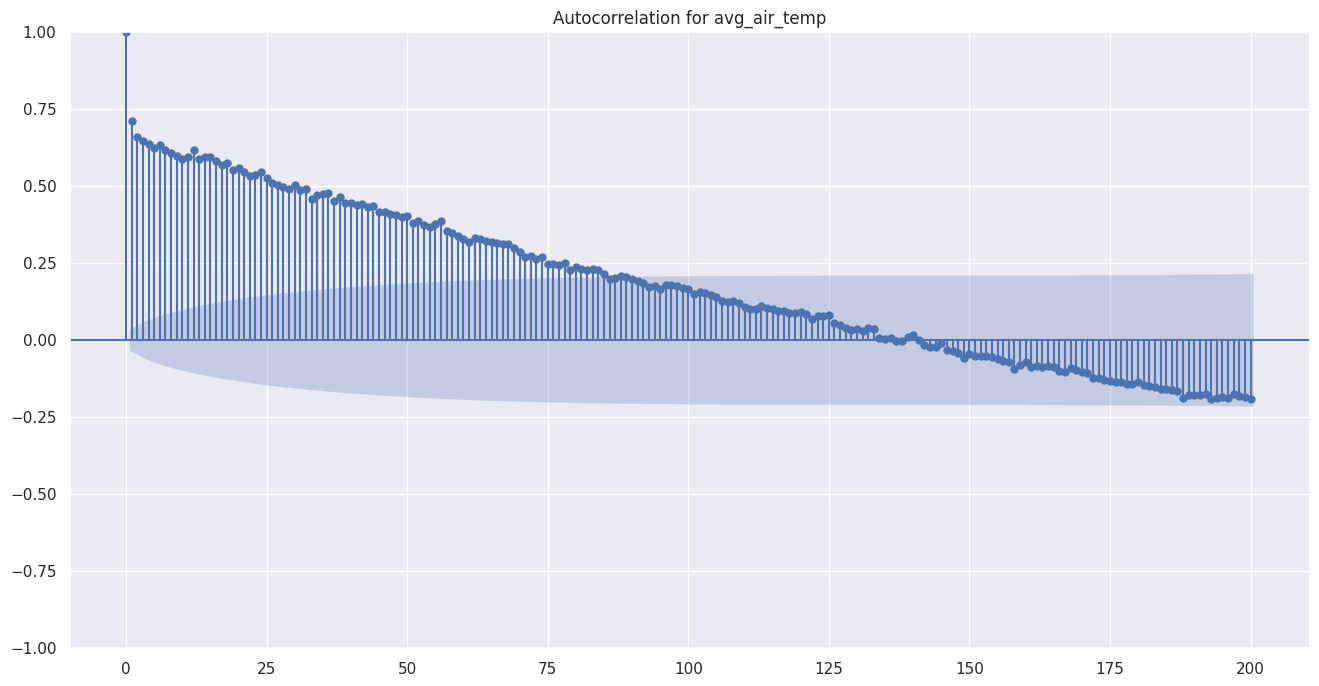


ADF Test Results for avg_air_temp:
ADF Statistic: -4.011296905040713
P-Value: 0.0013524989523056076
Lags Used: 14, Observations: 3182
Critical Values:
	1%: -3.4324067514593626
	5%: -2.8624487475060336
	10%: -2.5672537469447287


In [52]:
decompose_adf(mars_df,'avg_air_temp')

As one might expect, air temperature is highly autocorrelated.

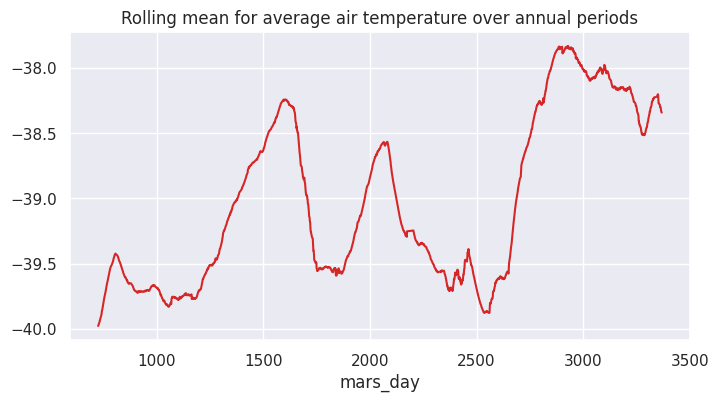

In [53]:
# Create the plot
ax = mars_df['avg_air_temp'].rolling(window=668).mean().plot(
    figsize=(8, 4), 
    color="tab:red", 
    title="Rolling mean for average air temperature over annual periods"
)

title = ax.get_title()

plt.savefig(os.path.join(PLOT_PATH, '02 - ' + title + '.png'), dpi=300, bbox_inches='tight')

plt.show()

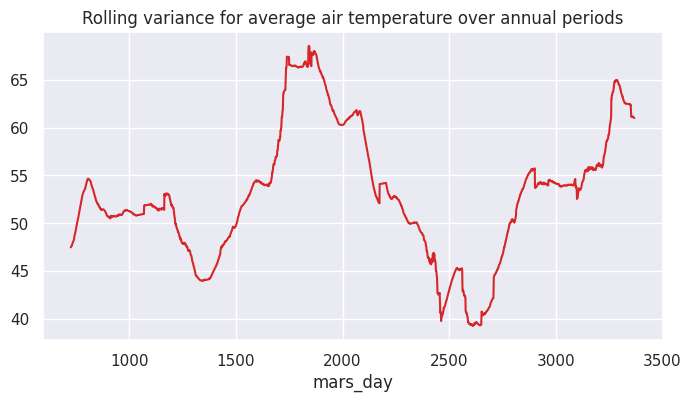

In [54]:
ax = mars_df['avg_air_temp'].rolling(window = 668).var().plot(figsize=(8,4), color="tab:red", title="Rolling variance for average air temperature over annual periods")
title = ax.get_title()

plt.savefig(os.path.join(PLOT_PATH, '02 - ' + title + '.png'), dpi=300, bbox_inches='tight')

plt.show()

### **3.2 Ground Temperature**

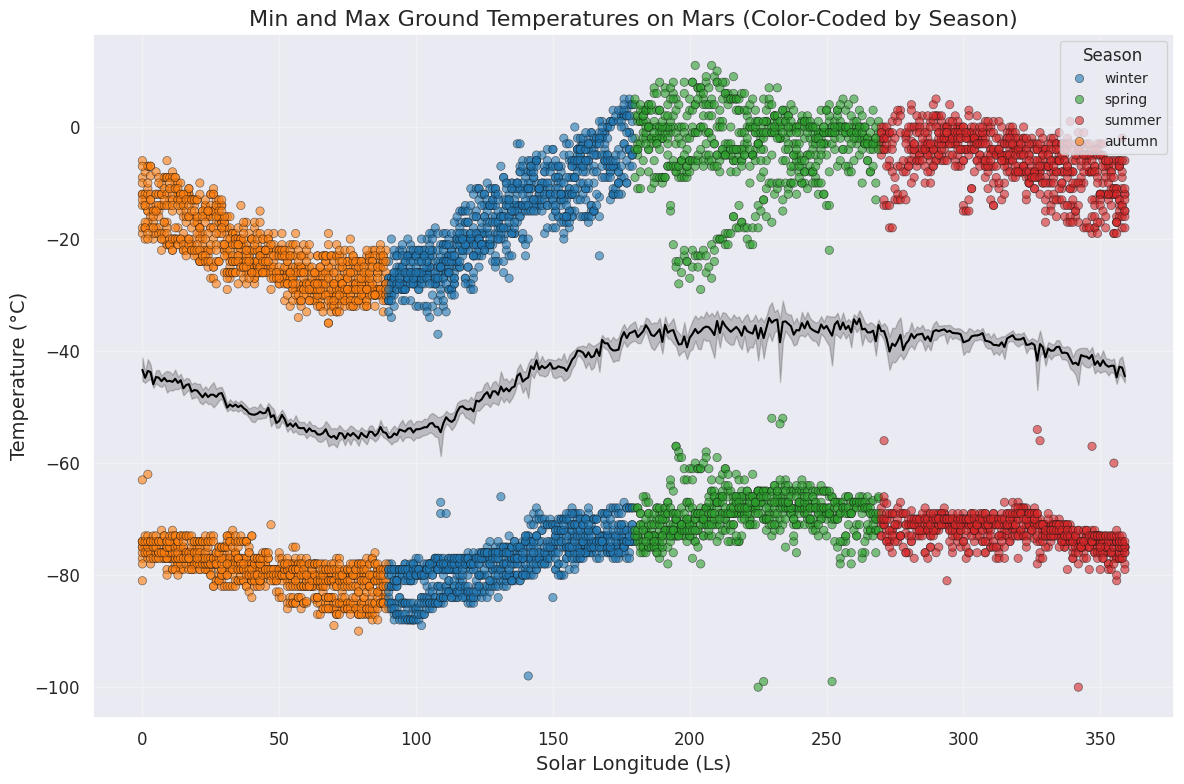

In [55]:
# Set up the figure
plt.figure(figsize=(12, 8))

# Scatter plot for min ground temperature
sns.scatterplot(
    data=mars_df,
    x='Ls',
    y='min_ground_temp',
    hue='mars_season',
    palette=season_palette,
    alpha=0.6,
    edgecolor='k'
)

# Scatter plot for max ground temperature
sns.scatterplot(
    data=mars_df,
    x='Ls',
    y='max_ground_temp',
    hue='mars_season',
    palette=season_palette,
    alpha=0.6,
    edgecolor='k'
)

# Line plot for average ground temperatures
sns.lineplot(
    data=mars_df,
    x='Ls',
    y='avg_ground_temp',
    color='black'
)

# Customize the plot
plt.title('Min and Max Ground Temperatures on Mars (Color-Coded by Season)', fontsize=16)
plt.xlabel('Solar Longitude (Ls)', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)

# Fix the legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title='Season', fontsize=10, title_fontsize=12, loc='upper right')

plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Min and Max Ground Temperatures on Mars (Color-Coded by Season).png'))
plt.show()

Ground temperature appears to have significantly less variation than air temperature. We do however see a large deviation from the standard structure in the Spring season. This large deviation turns out to be a massive dust storm that occured in 2018.

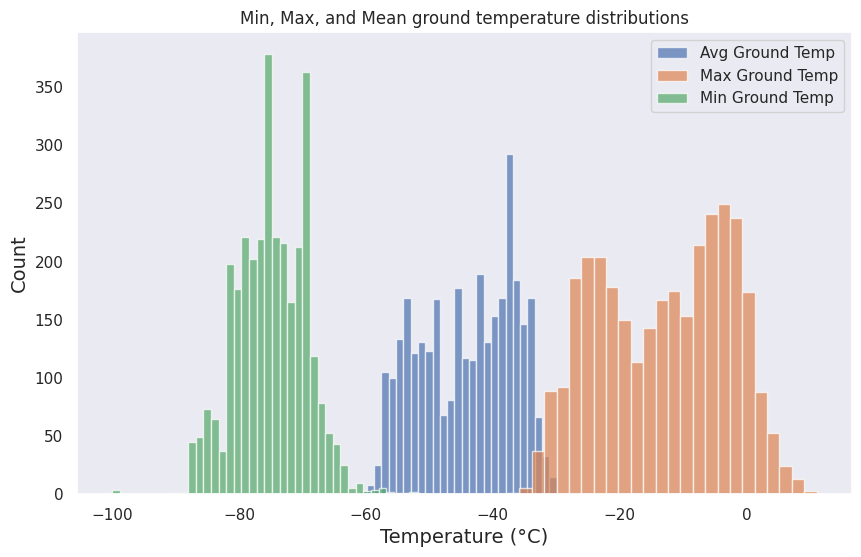

In [56]:
plt.figure(figsize=(10,6))
mars_df['avg_ground_temp'].hist(bins=40, alpha=0.7, label='Avg Ground Temp')
mars_df['max_ground_temp'].hist(bins=40, alpha=0.7, label='Max Ground Temp')
mars_df['min_ground_temp'].hist(bins=40, alpha=0.7, label='Min Ground Temp')
plt.grid(False)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Min, Max, and Mean ground temperature distributions')
plt.legend()

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Min, Max, and Mean ground temperature distributions.png'))
plt.show()

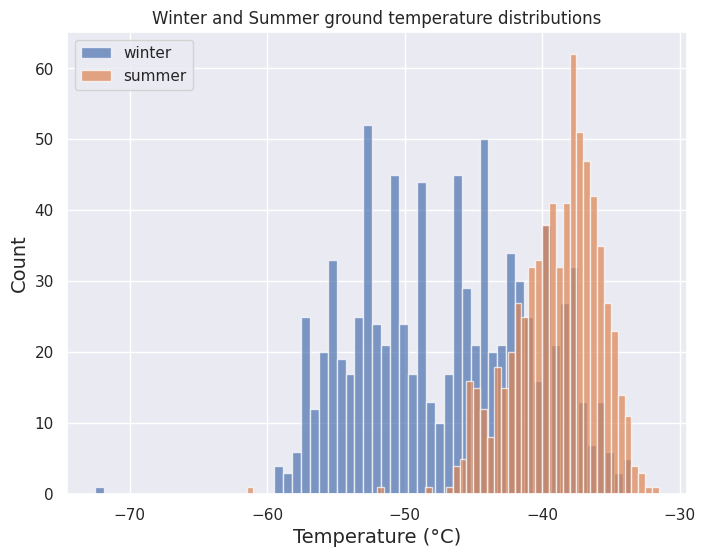

In [57]:
plt.figure(figsize=(8,6))
mars_df[mars_df['mars_season'] == 'winter']['avg_ground_temp'].hist(bins=60, alpha=0.7, label='winter')
mars_df[mars_df['mars_season'] == 'summer']['avg_ground_temp'].hist(bins=60, alpha=0.7, label='summer')
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Winter and Summer ground temperature distributions')
plt.legend()

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Winter and Summer ground temperature distributions.png'))
plt.show()

It appears that ground temperature holds all the same seasonal trends while maintaining seasonal trends and the temperature impact from the global dust storm in 2018.

Ground temperature is likely to be a superior predictor for martian temperature. Do hypothesis testing to confirm.

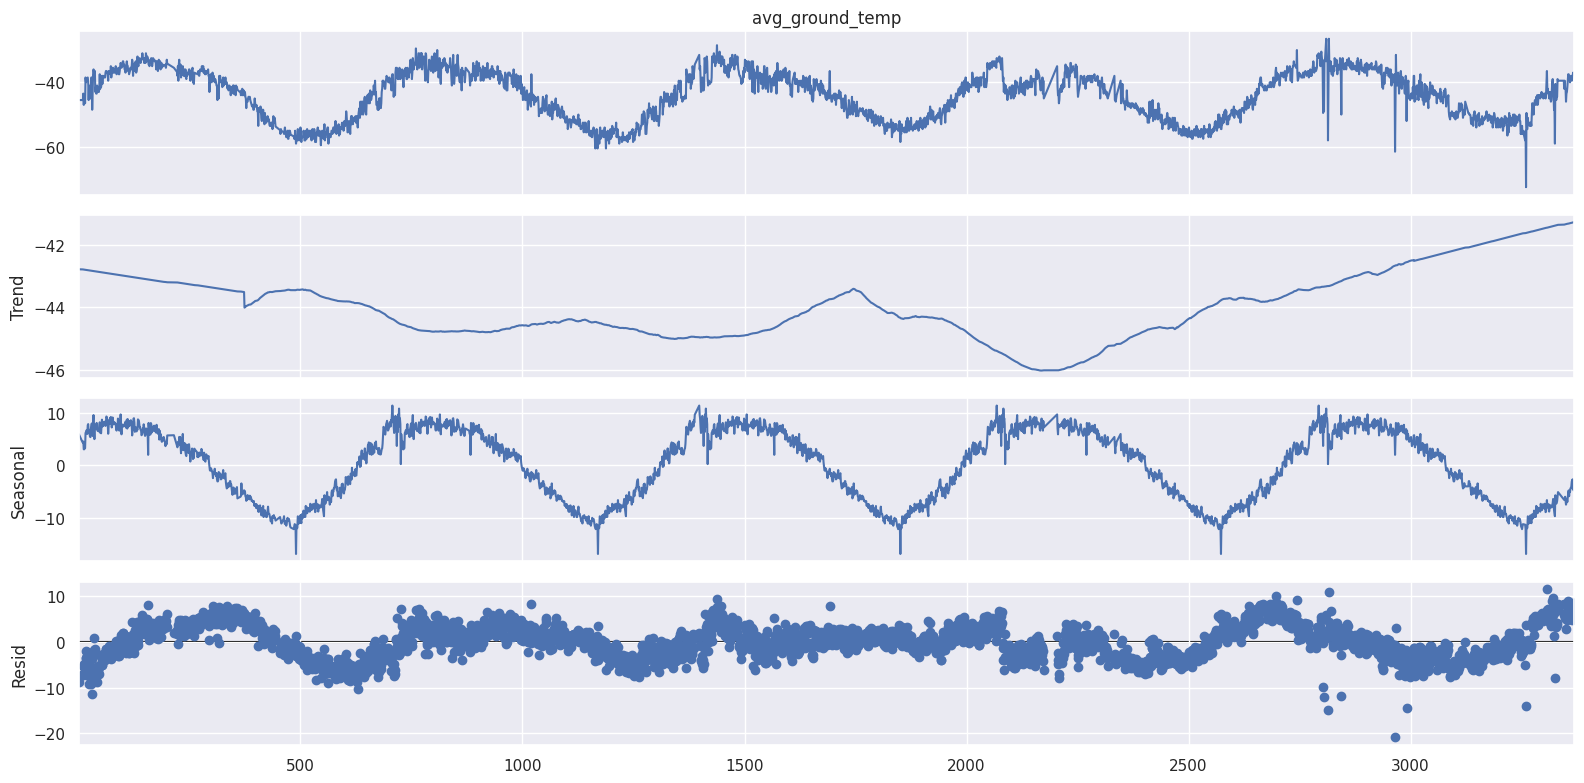

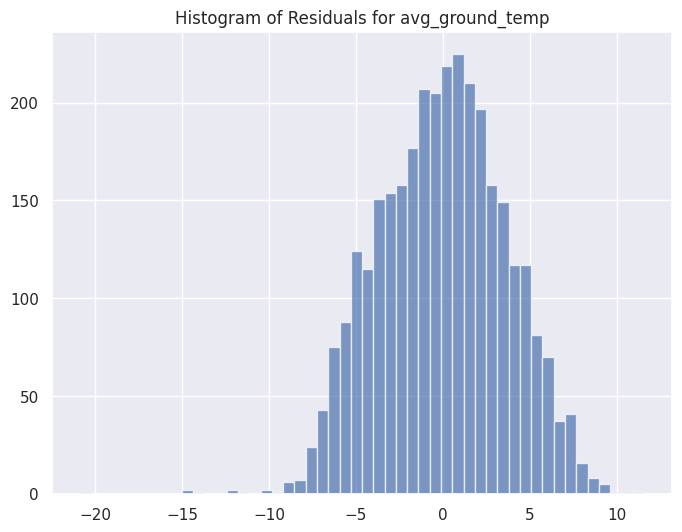

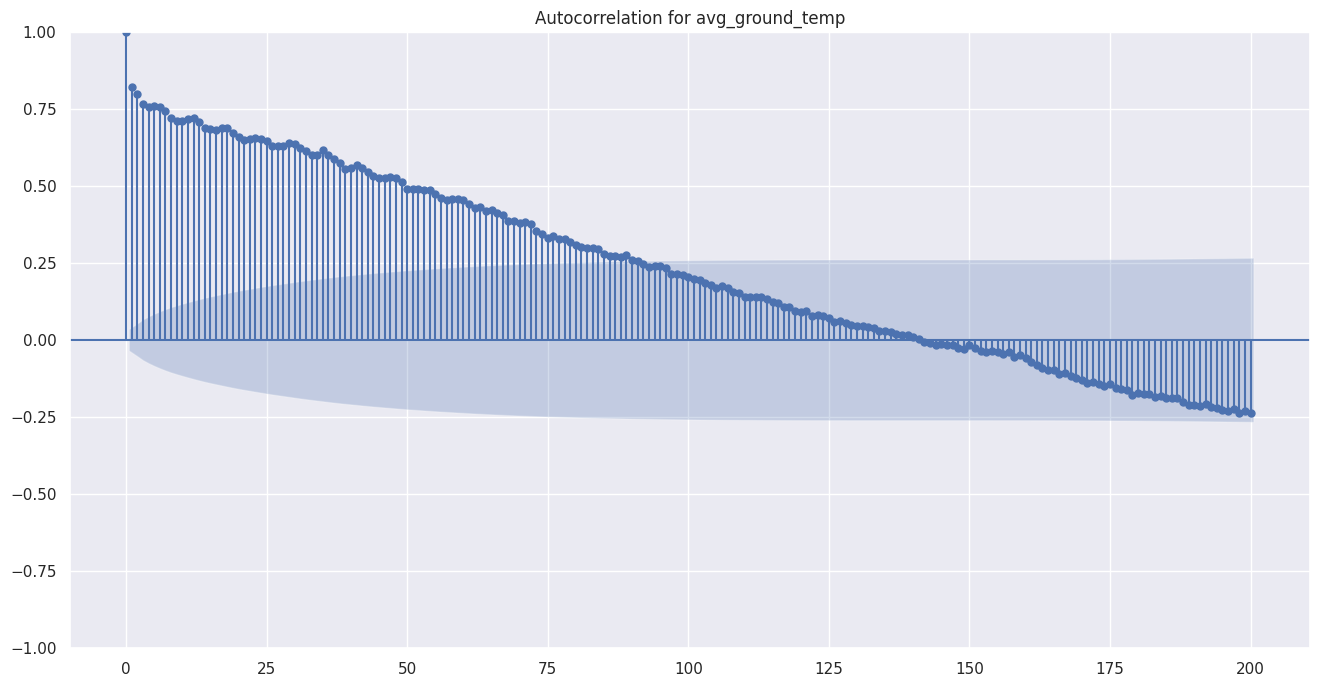


ADF Test Results for avg_ground_temp:
ADF Statistic: -2.641135179489979
P-Value: 0.08478994166886267
Lags Used: 28, Observations: 3168
Critical Values:
	1%: -3.4324158480194886
	5%: -2.862452765302856
	10%: -2.5672558859467465


In [58]:
decompose_adf(mars_df, 'avg_ground_temp')

It is a bit strange that ground temperature seems to be less autocorrelated than air temperature. The differences between air and ground temperature will be worth exploring in a later notebook as there are likely different primary factors affecting temperature.

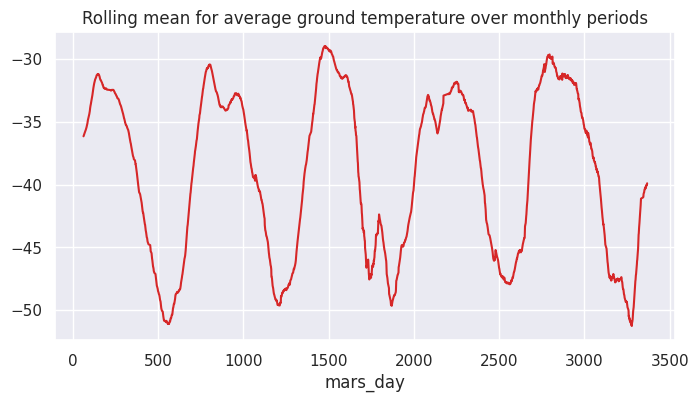

In [59]:
ax = mars_df['avg_air_temp'].rolling(window = 56).mean().plot(figsize=(8,4), color="tab:red", title="Rolling mean for average ground temperature over monthly periods")
title = ax.get_title()

plt.savefig(os.path.join(PLOT_PATH, '02 - ' + title + '.png'), dpi=300, bbox_inches='tight')

plt.show()

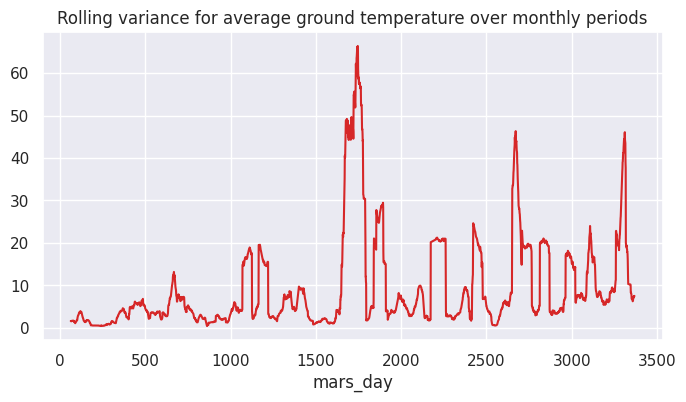

In [60]:
ax = mars_df['avg_air_temp'].rolling(window = 56).var().plot(figsize=(8,4), color="tab:red", title="Rolling variance for average ground temperature over monthly periods")
title = ax.get_title()

plt.savefig(os.path.join(PLOT_PATH, '02 - ' + title + '.png'), dpi=300, bbox_inches='tight')

plt.show()

---

## **4. Atmospheric Pressure**

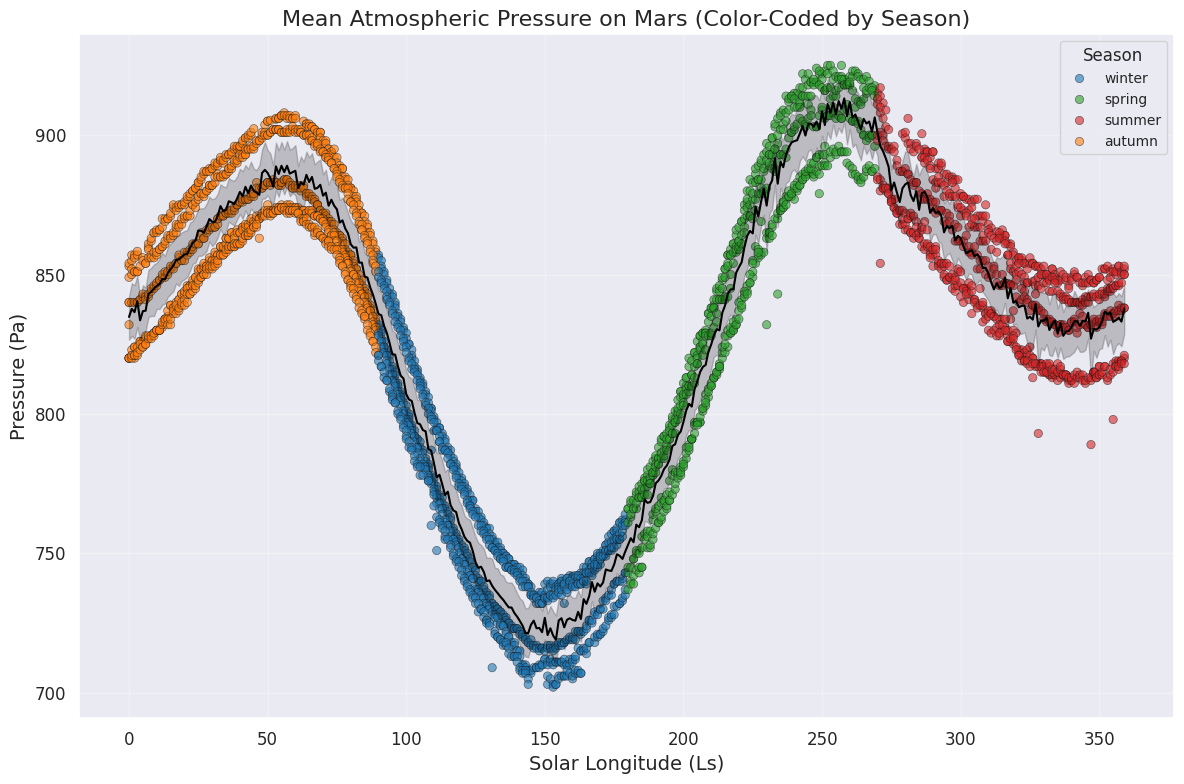

In [61]:
# Set up the figure
plt.figure(figsize=(12, 8))

# Scatter plot
sns.scatterplot(
    data=mars_df,
    x='Ls',
    y='mean_pressure',
    hue='mars_season',
    palette=season_palette,
    alpha=0.6,
    edgecolor='k'
)


# Line plot
sns.lineplot(
    data=mars_df,
    x='Ls',
    y='mean_pressure',
    color='black'
)

# Customize the plot
plt.title('Mean Atmospheric Pressure on Mars (Color-Coded by Season)', fontsize=16)
plt.xlabel('Solar Longitude (Ls)', fontsize=14)
plt.ylabel('Pressure (Pa)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)

# Fix the legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title='Season', fontsize=10, title_fontsize=12, loc='upper right')

plt.tight_layout()

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Mean Atmospheric Pressure on Mars (Color-Coded by Season).png'))
plt.show()

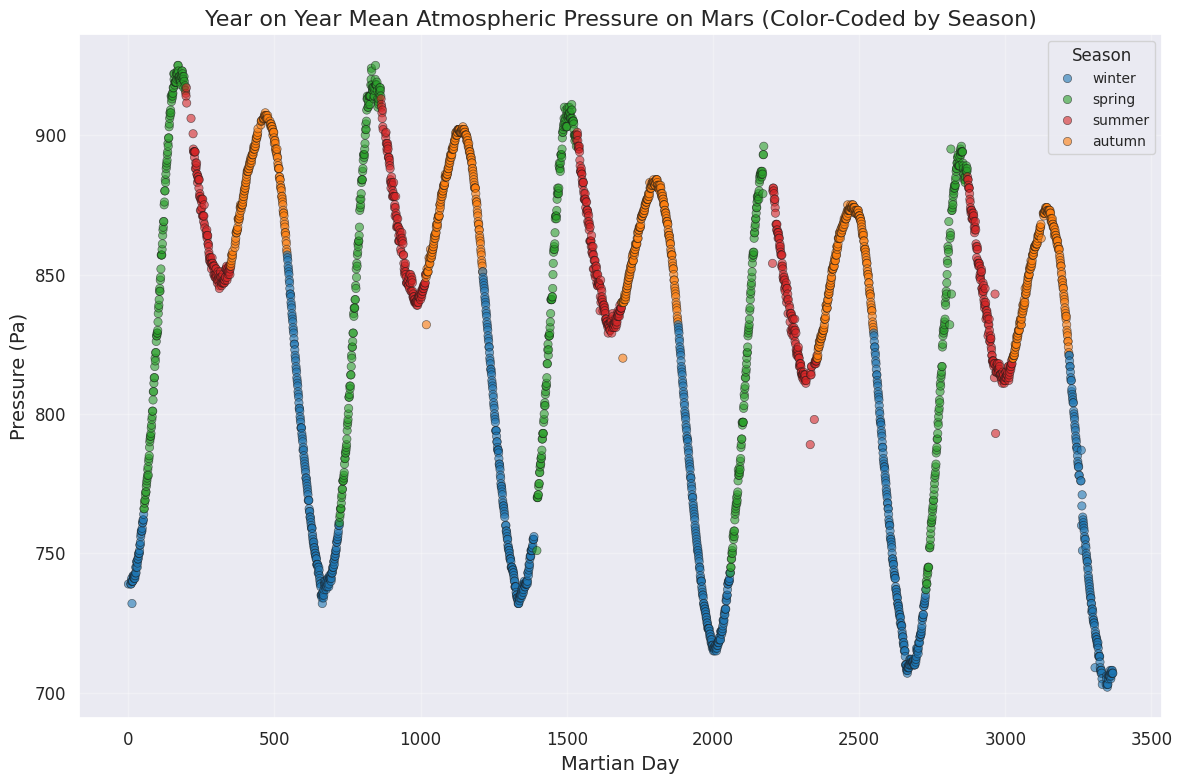

In [62]:
# Set up the figure
plt.figure(figsize=(12, 8))

# Scatter plot
sns.scatterplot(
    data=mars_df,
    x='mars_day',
    y='mean_pressure',
    hue='mars_season',
    palette=season_palette,
    alpha=0.6,
    edgecolor='k'
)

# Customize the plot
plt.title('Year on Year Mean Atmospheric Pressure on Mars (Color-Coded by Season)', fontsize=16)
plt.xlabel('Martian Day', fontsize=14)
plt.ylabel('Pressure (Pa)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)

# Fix the legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title='Season', fontsize=10, title_fontsize=12, loc='upper right')

plt.tight_layout()

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Year on Year Mean Atmospheric Pressure on Mars (Color-Coded by Season).png'))
plt.show()

This is an increadibly interesting bimodal pattern which could indicate several driving factors influencing annual atmospheric pressure trends. There are two serperate minima and maxima. The primary driver could be due to sublimation of the carbon dioxide layer in the Martian polar ice caps. An additional driver stem from asymmetrical solar heating between hemisphers due to the elliptical nature of Mars' orbit.

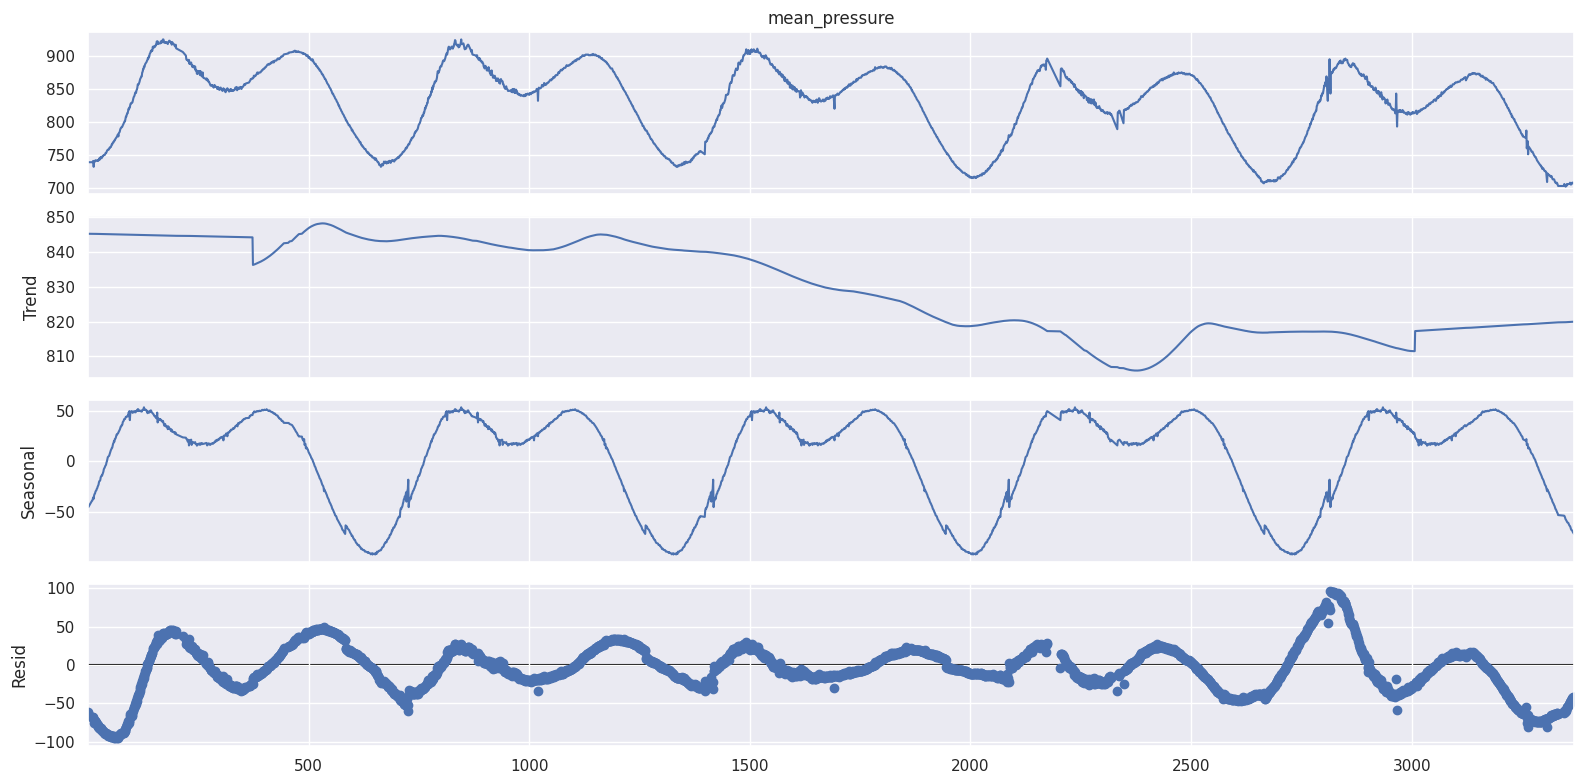

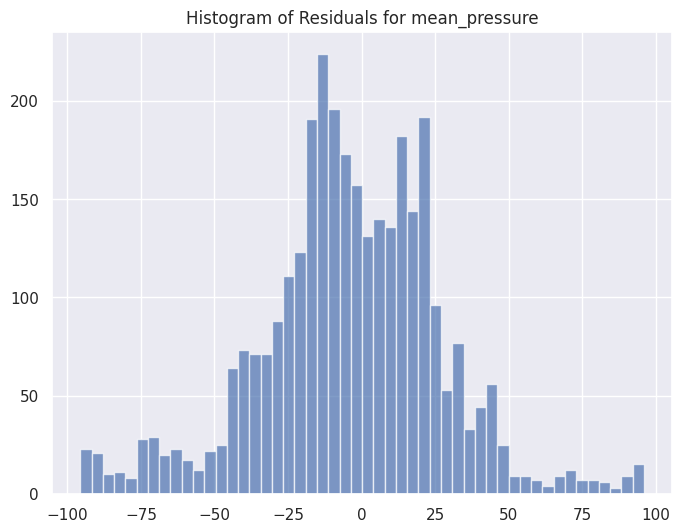

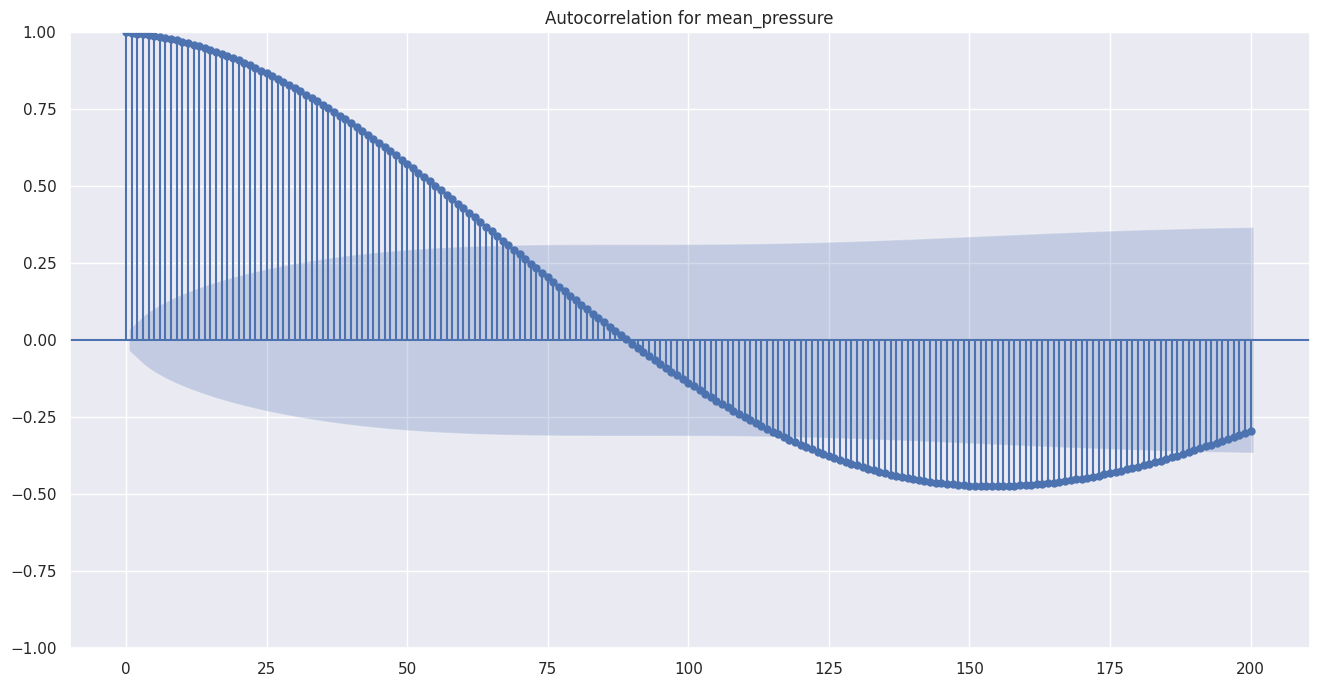


ADF Test Results for mean_pressure:
ADF Statistic: -7.510178575894858
P-Value: 4.034963642058802e-11
Lags Used: 24, Observations: 3172
Critical Values:
	1%: -3.4324132408020374
	5%: -2.8624516137402374
	10%: -2.5672552728755234


In [63]:
decompose_adf(mars_df,'mean_pressure')

Pressure is extremely autocorrelated with strong seasonal trends. It is interesting to note that the seasonal trend is bimodal. 

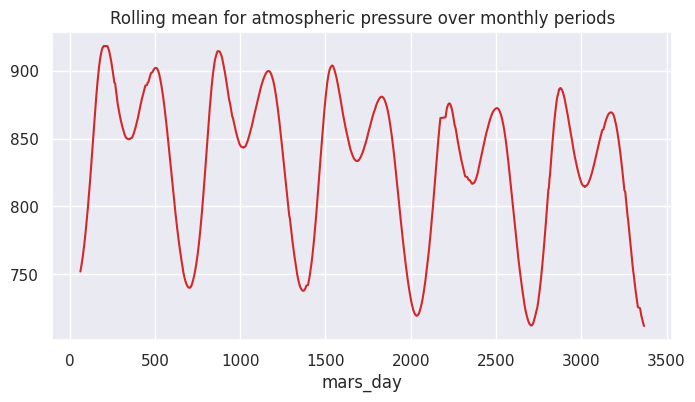

In [64]:
ax = mars_df['mean_pressure'].rolling(window = 56).mean().plot(figsize=(8,4), color="tab:red", title="Rolling mean for atmospheric pressure over monthly periods")
title = ax.get_title()

plt.savefig(os.path.join(PLOT_PATH, '02 - ' + title + '.png'), dpi=300, bbox_inches='tight')

plt.show()

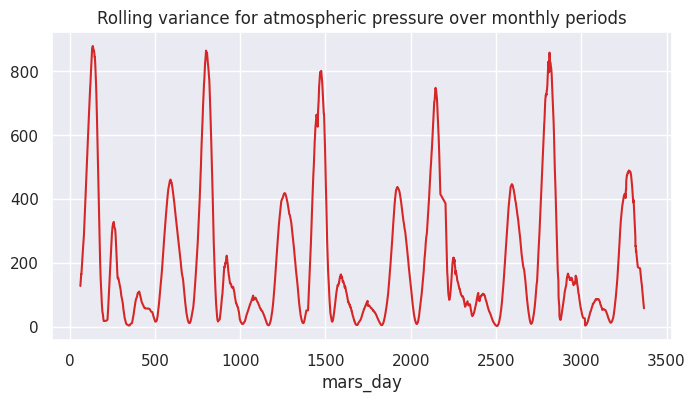

In [65]:
ax = mars_df['mean_pressure'].rolling(window = 56).var().plot(figsize=(8,4), color="tab:red", title="Rolling variance for atmospheric pressure over monthly periods")
title = ax.get_title()

plt.savefig(os.path.join(PLOT_PATH, '02 - ' + title + '.png'), dpi=300, bbox_inches='tight')

plt.show()

---

## **5. UV Radiation**

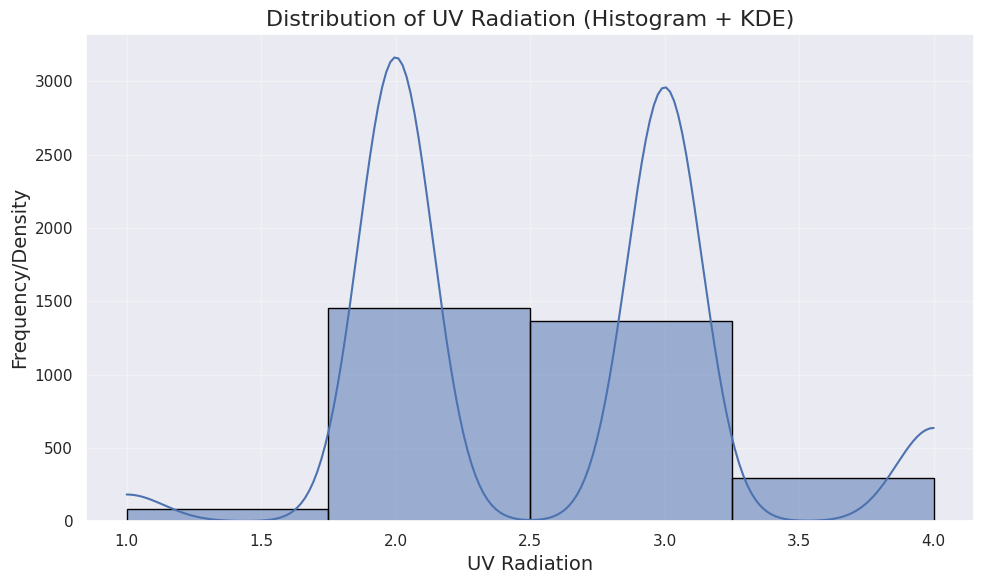

In [66]:
# Combined plot (Histogram + KDE)
plt.figure(figsize=(10, 6))
sns.histplot(mars_df['UV_Radiation'], bins=4, kde=True, color='b', edgecolor='black')
plt.title('Distribution of UV Radiation (Histogram + KDE)', fontsize=16)
plt.xlabel('UV Radiation', fontsize=14)
plt.ylabel('Frequency/Density', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Distribution of UV Radiation (Histogram + KDE).png'))
plt.show()

Most days have are listed as 'Moderate' and 'High' UV Radiation days. It would be interesting to see how this looks across each seasoon.

<Figure size 1500x1000 with 0 Axes>

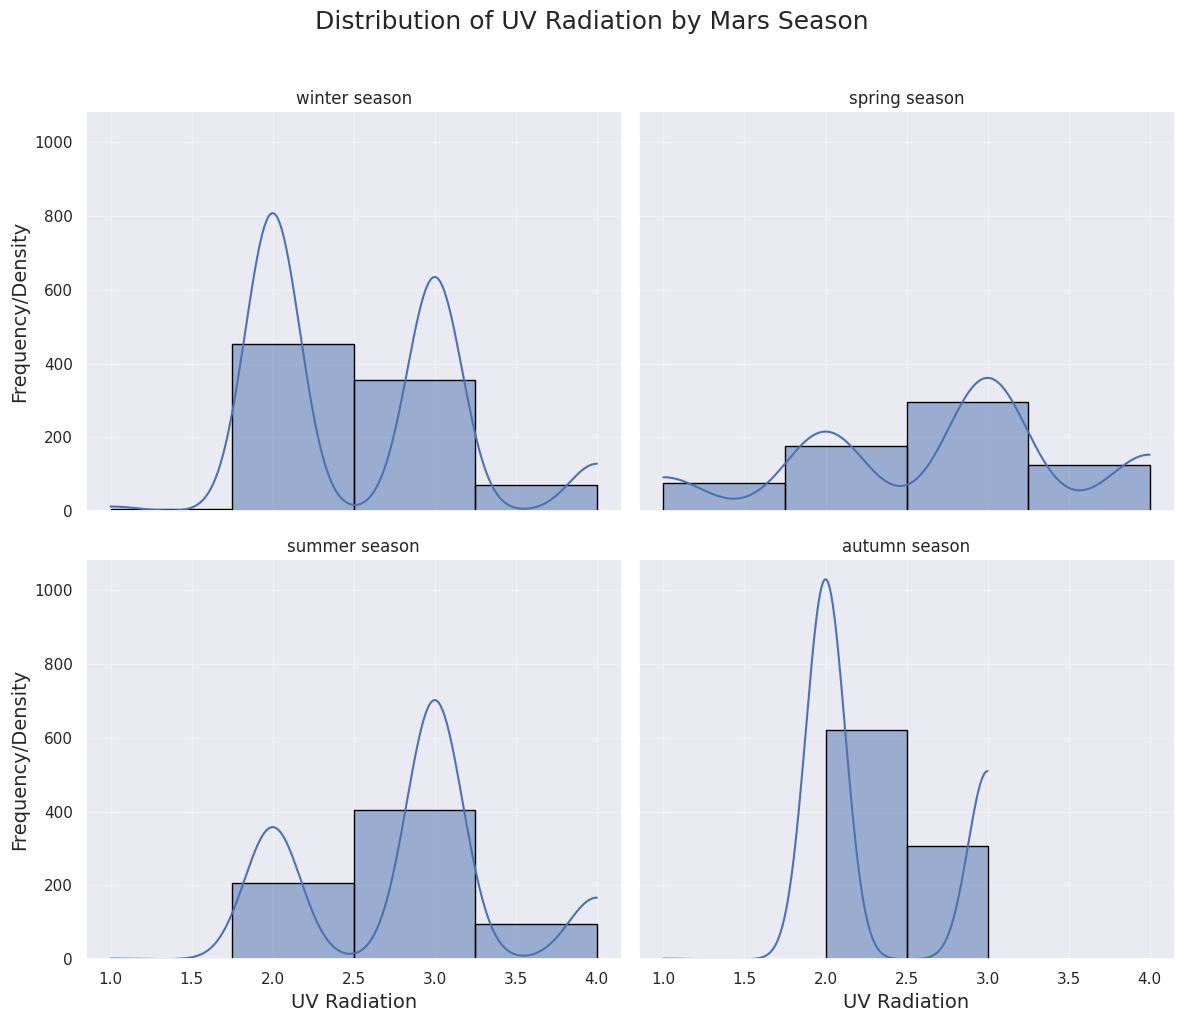

In [67]:
# Separate plots for each Mars season
plt.figure(figsize=(15, 10))

# Create a FacetGrid to separate by mars_season
g = sns.FacetGrid(mars_df, col='mars_season', height=5, aspect=1.2, col_wrap=2)

# Map the histplot with KDE for each season
g.map_dataframe(sns.histplot, x='UV_Radiation', bins=4, kde=True, color='b', edgecolor='black')

# Add titles and labels
g.set_axis_labels('UV Radiation', 'Frequency/Density', fontsize=14)
g.set_titles(col_template='{col_name} season', fontsize=16)
g.fig.suptitle('Distribution of UV Radiation by Mars Season', fontsize=18, y=1.02)

# Adjust the aesthetics
g.fig.tight_layout()
for ax in g.axes.flat:
    ax.grid(alpha=0.3)

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Distribution of UV Radiation by Mars Season.png'))
plt.show()

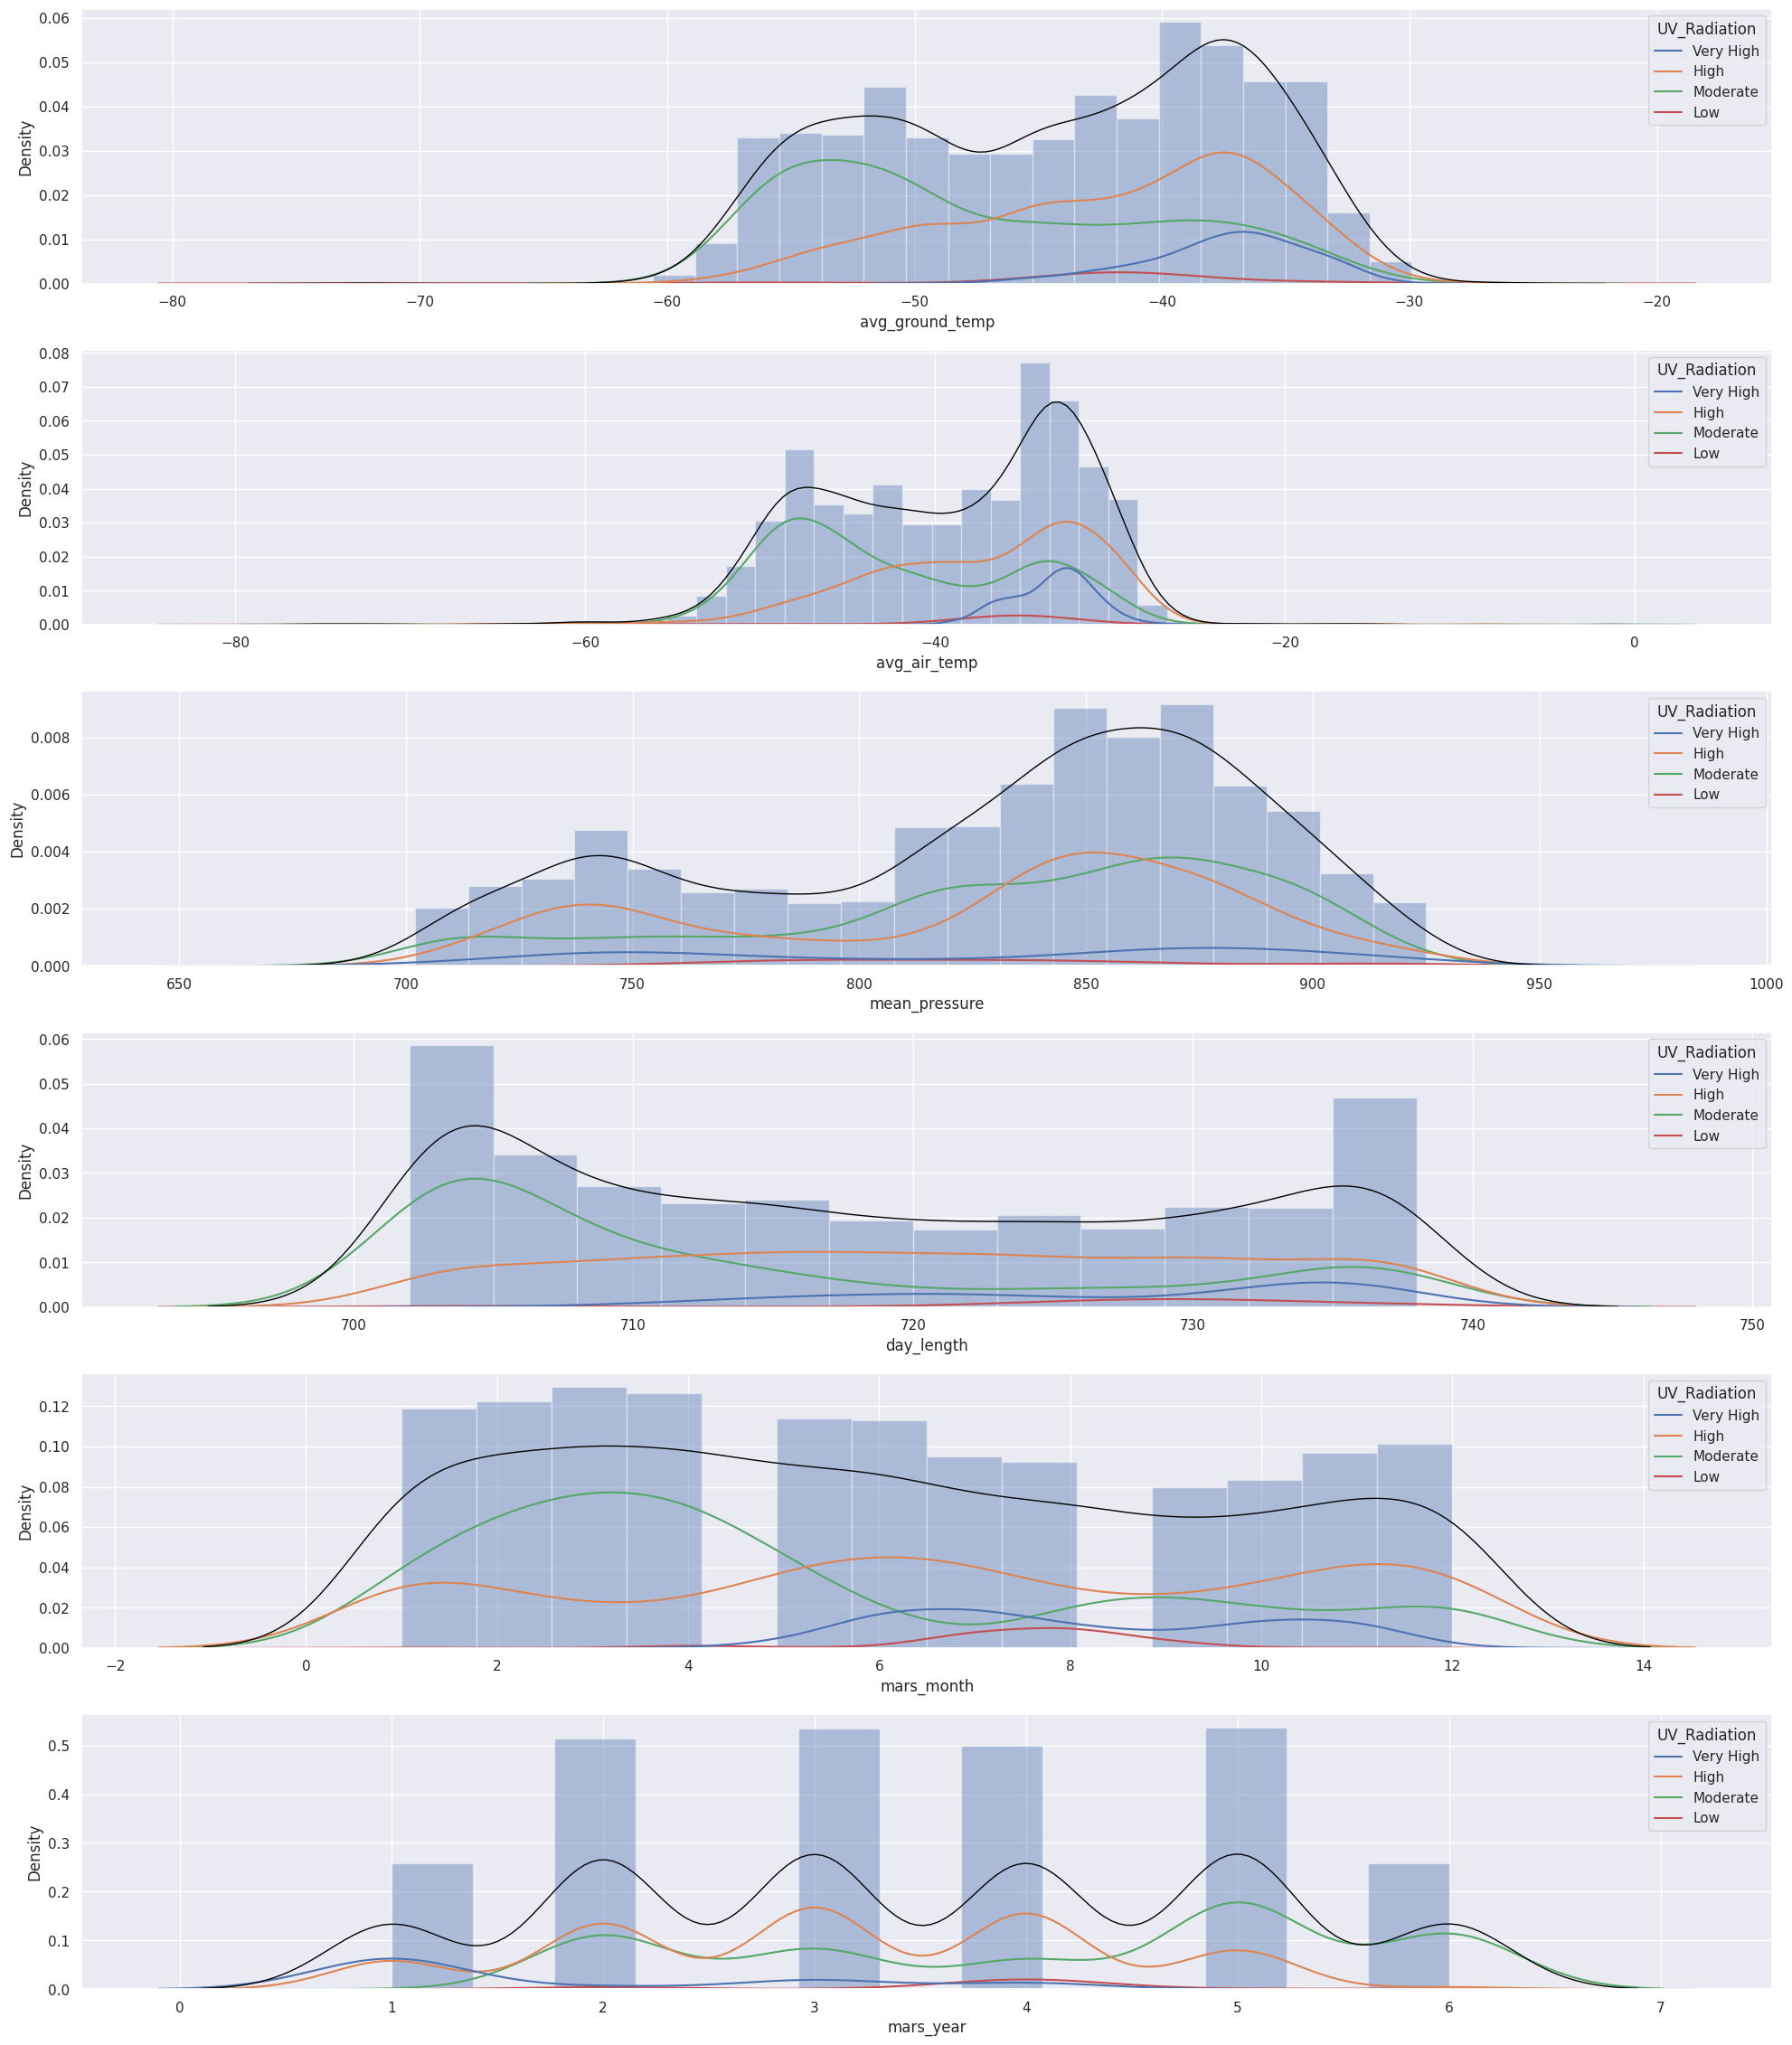

In [68]:
# Define the mapping for UV Radiation categories
uv_categories = {1: "Low", 2: "Moderate", 3: "High", 4: "Very High"}

# Create a copy of the dataframe
mars_df_copy = mars_df.copy()

# Map the UV Radiation values to their descriptive categories
mars_df_copy["UV_Radiation"] = mars_df_copy["UV_Radiation"].map(uv_categories)

# Define columns to plot
colms = ['avg_ground_temp', 'avg_air_temp', 'mean_pressure',
         'day_length', 'mars_month', 'mars_year']

plt.figure(figsize=(20,60))
for i in range(len(colms)):
    plt.subplot(16, 1, i+1)
    # Use the copied dataframe with mapped UV categories
    sns.kdeplot(data=mars_df_copy, x=colms[i], hue="UV_Radiation")
    sns.distplot(mars_df[colms[i]], kde_kws={"color": "black", "lw": 1, "label": "KDE"}, hist_kws={"color": "b"})

plt.tight_layout()

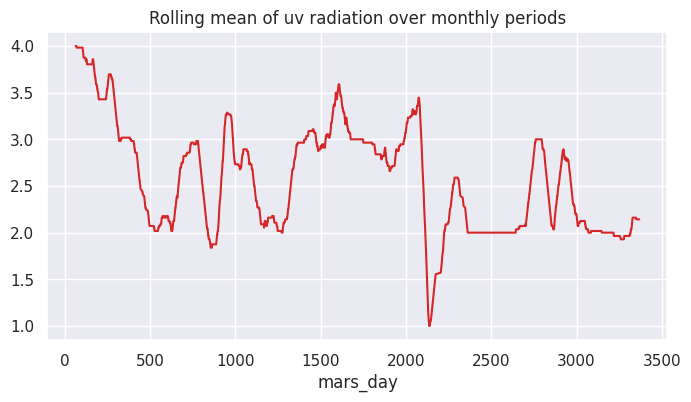

In [69]:
ax = mars_df['UV_Radiation'].rolling(window = 56).mean().plot(figsize=(8,4), color="tab:red", title="Rolling mean of uv radiation over monthly periods")
title = ax.get_title()

plt.savefig(os.path.join(PLOT_PATH, '02 - ' + title + '.png'), dpi=300, bbox_inches='tight')

plt.show()

---

## **6. Day Length**

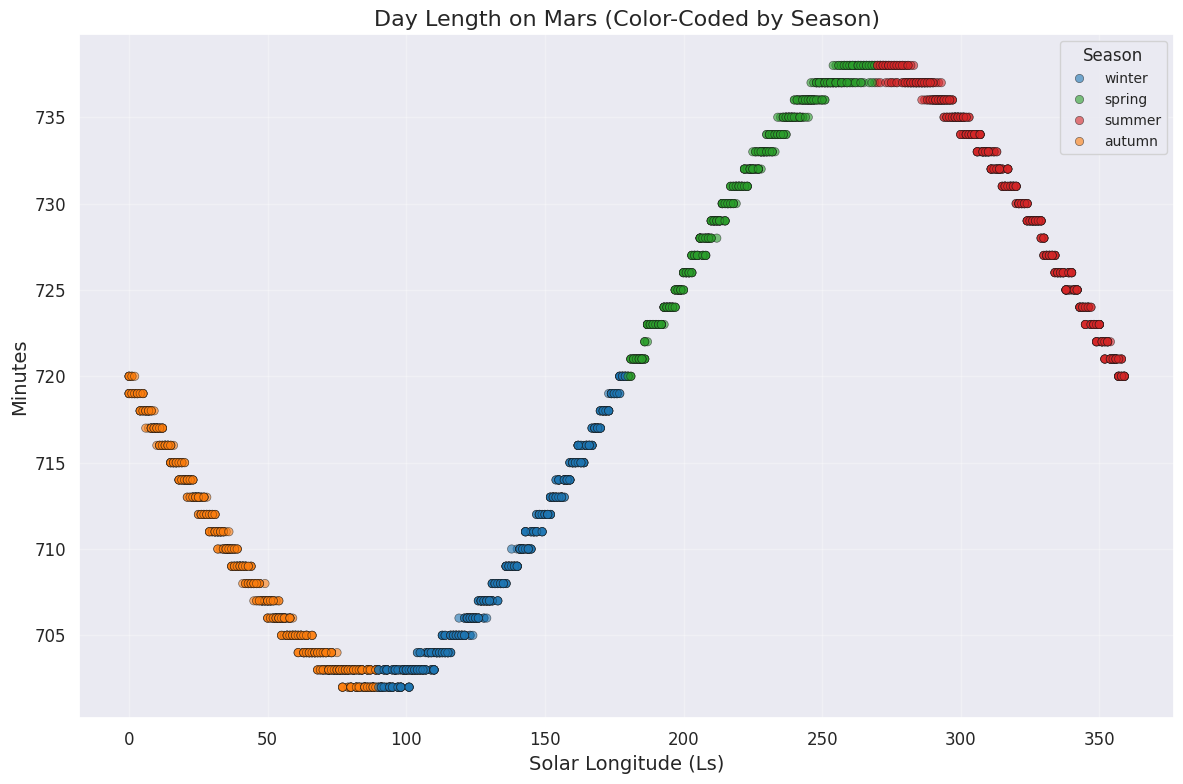

In [70]:
# Set up the figure
plt.figure(figsize=(12, 8))

# Scatter plot
sns.scatterplot(
    data=mars_df,
    x='Ls',
    y='day_length',
    hue='mars_season',
    palette=season_palette,
    alpha=0.6,
    edgecolor='k'
)

# Customize the plot
plt.title('Day Length on Mars (Color-Coded by Season)', fontsize=16)
plt.xlabel('Solar Longitude (Ls)', fontsize=14)
plt.ylabel('Minutes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)

# Fix the legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title='Season', fontsize=10, title_fontsize=12, loc='upper right')

plt.tight_layout()

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Day Length on Mars (Color-Coded by Season).png'))
plt.show()

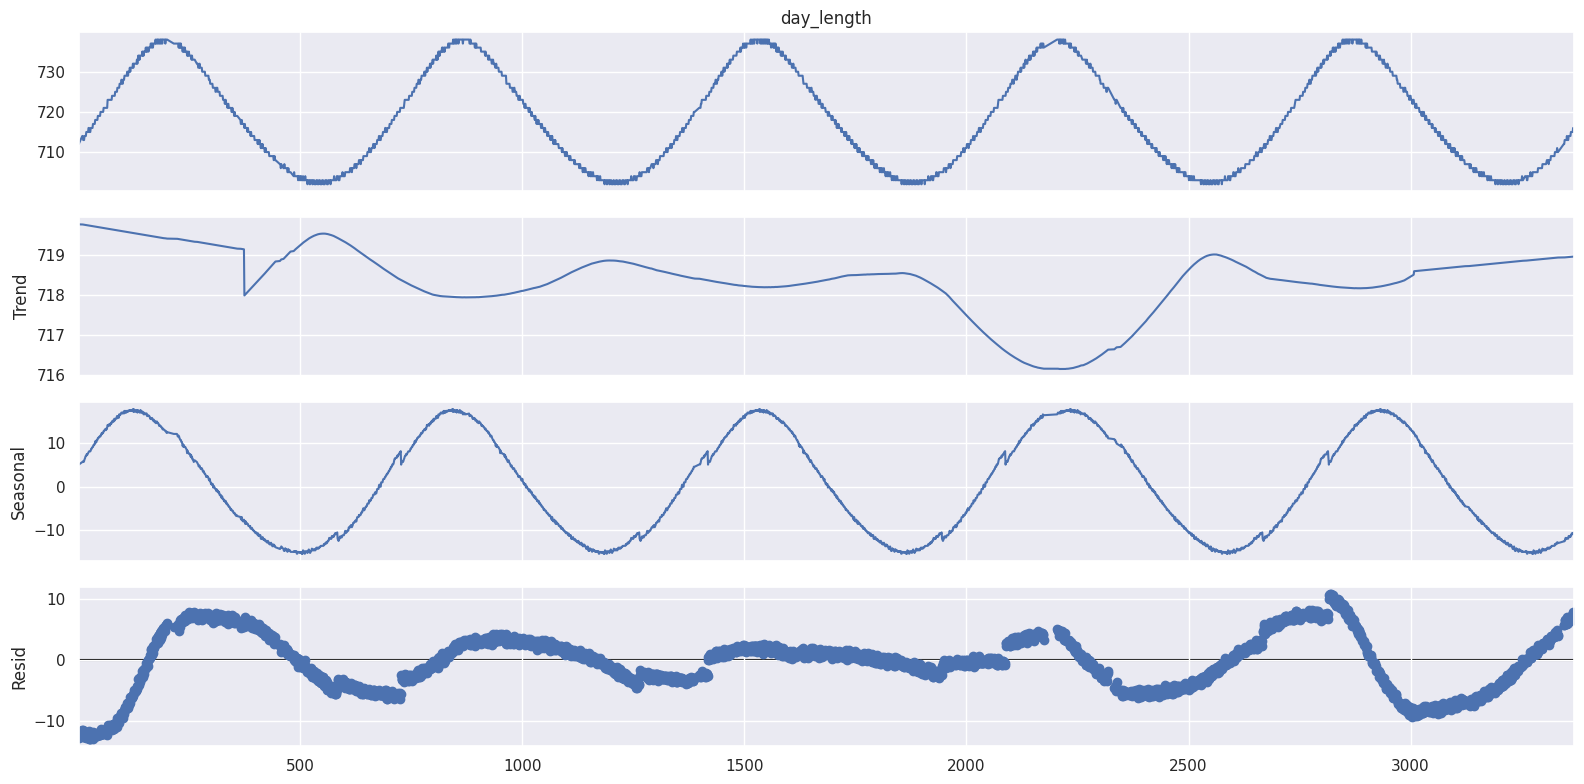

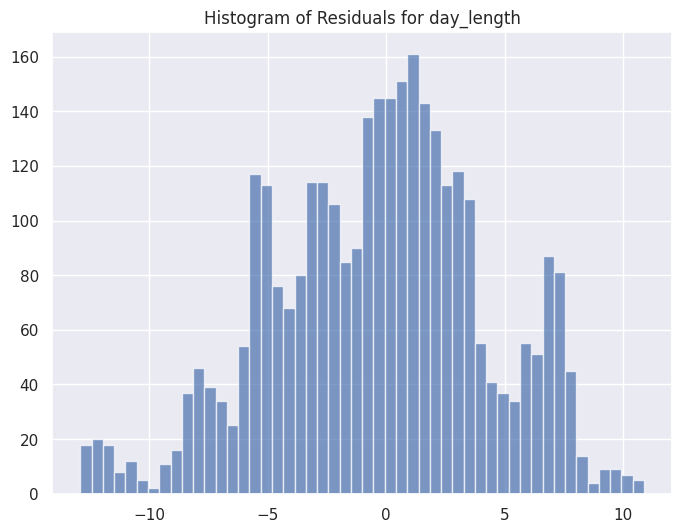

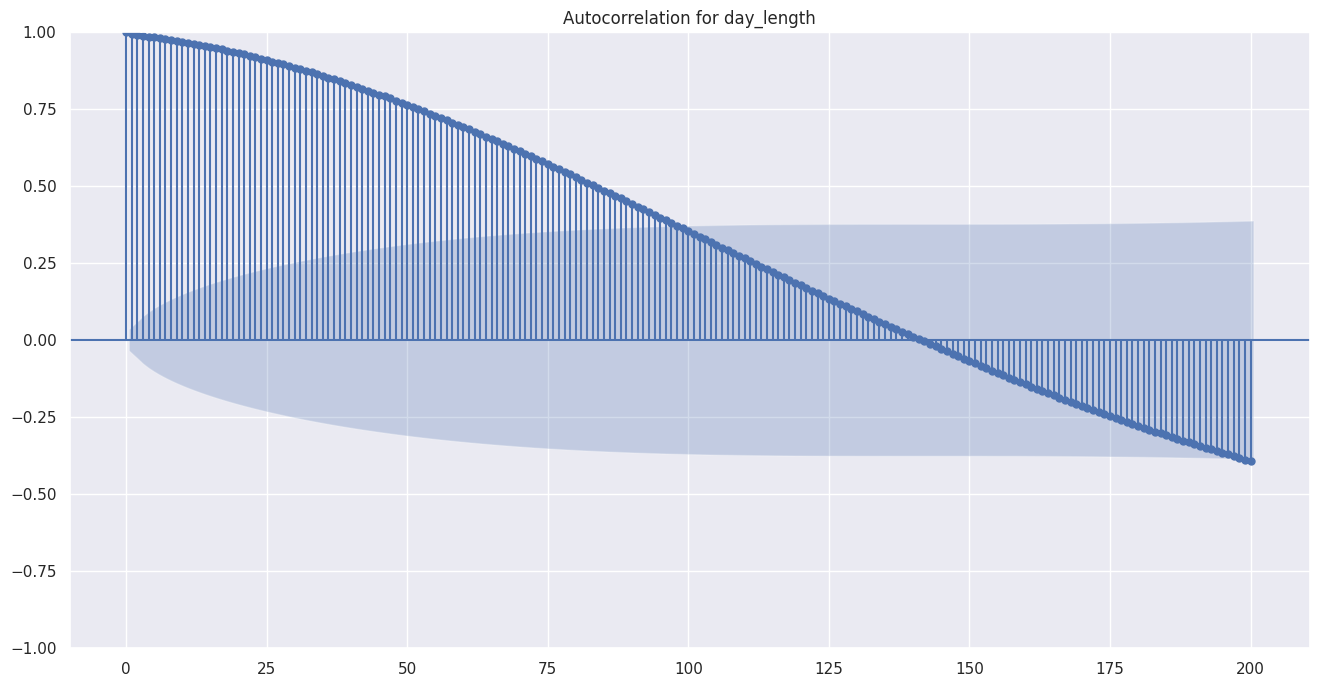


ADF Test Results for day_length:
ADF Statistic: -3.804877698664861
P-Value: 0.0028578021644512395
Lags Used: 28, Observations: 3168
Critical Values:
	1%: -3.4324158480194886
	5%: -2.862452765302856
	10%: -2.5672558859467465


In [71]:
decompose_adf(mars_df, 'day_length')

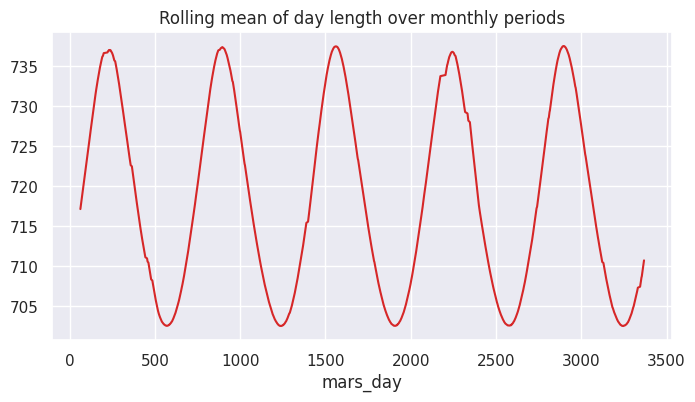

In [72]:
ax = mars_df['day_length'].rolling(window = 56).mean().plot(figsize=(8,4), color="tab:red", title="Rolling mean of day length over monthly periods")
title = ax.get_title()

plt.savefig(os.path.join(PLOT_PATH, '02 - ' + title + '.png'), dpi=300, bbox_inches='tight')

plt.show()

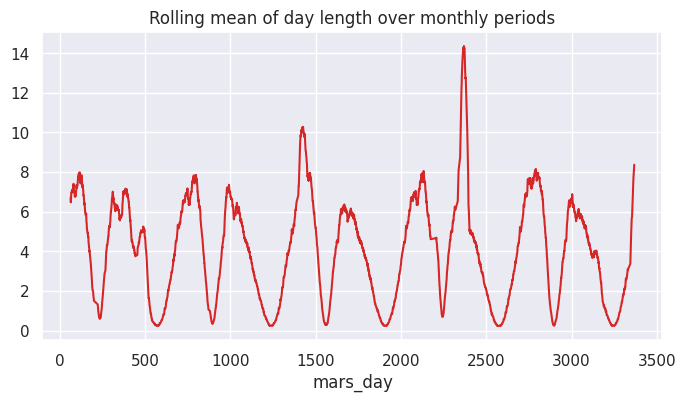

In [73]:
mars_df['day_length'].rolling(window = 56).var().plot(figsize=(8,4), color="tab:red", title="Rolling mean of day length over monthly periods")
title = ax.get_title()

plt.savefig(os.path.join(PLOT_PATH, '02 - ' + title + '.png'), dpi=300, bbox_inches='tight')

plt.show()

---

## **7. Correlation Between Features**

In [74]:
features = ['Ls',
            'day_length',
            'avg_ground_temp', 
            'avg_air_temp', 
            'mean_pressure', 
            'UV_Radiation']
sns.set(rc={"figure.figsize":(16, 8)})

### **7.1 Annual Trends**

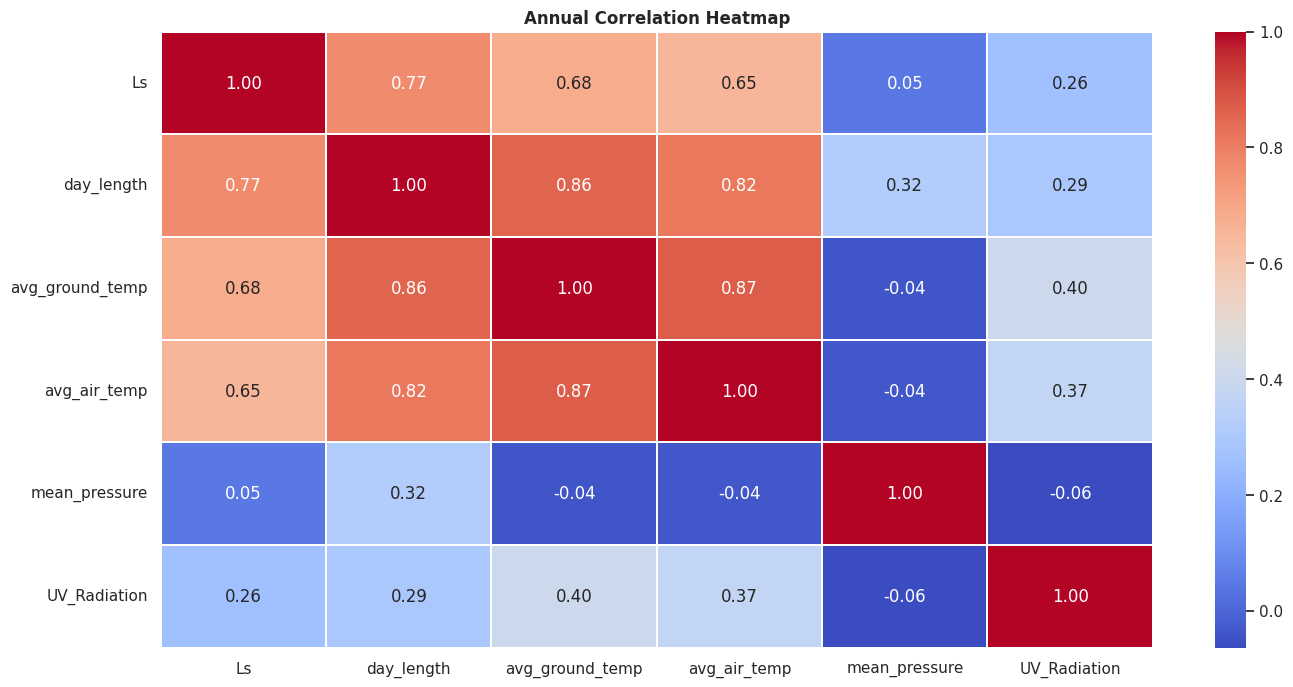

In [75]:
corr = mars_df[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.05)
plt.title('Annual Correlation Heatmap', weight='bold')

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Annual Correlation Heatmap.png'))
plt.show()

Pressure seems to be uncorrelated with anything besides day length. The should not be the case, a more detailed picture is required to test for correlation.

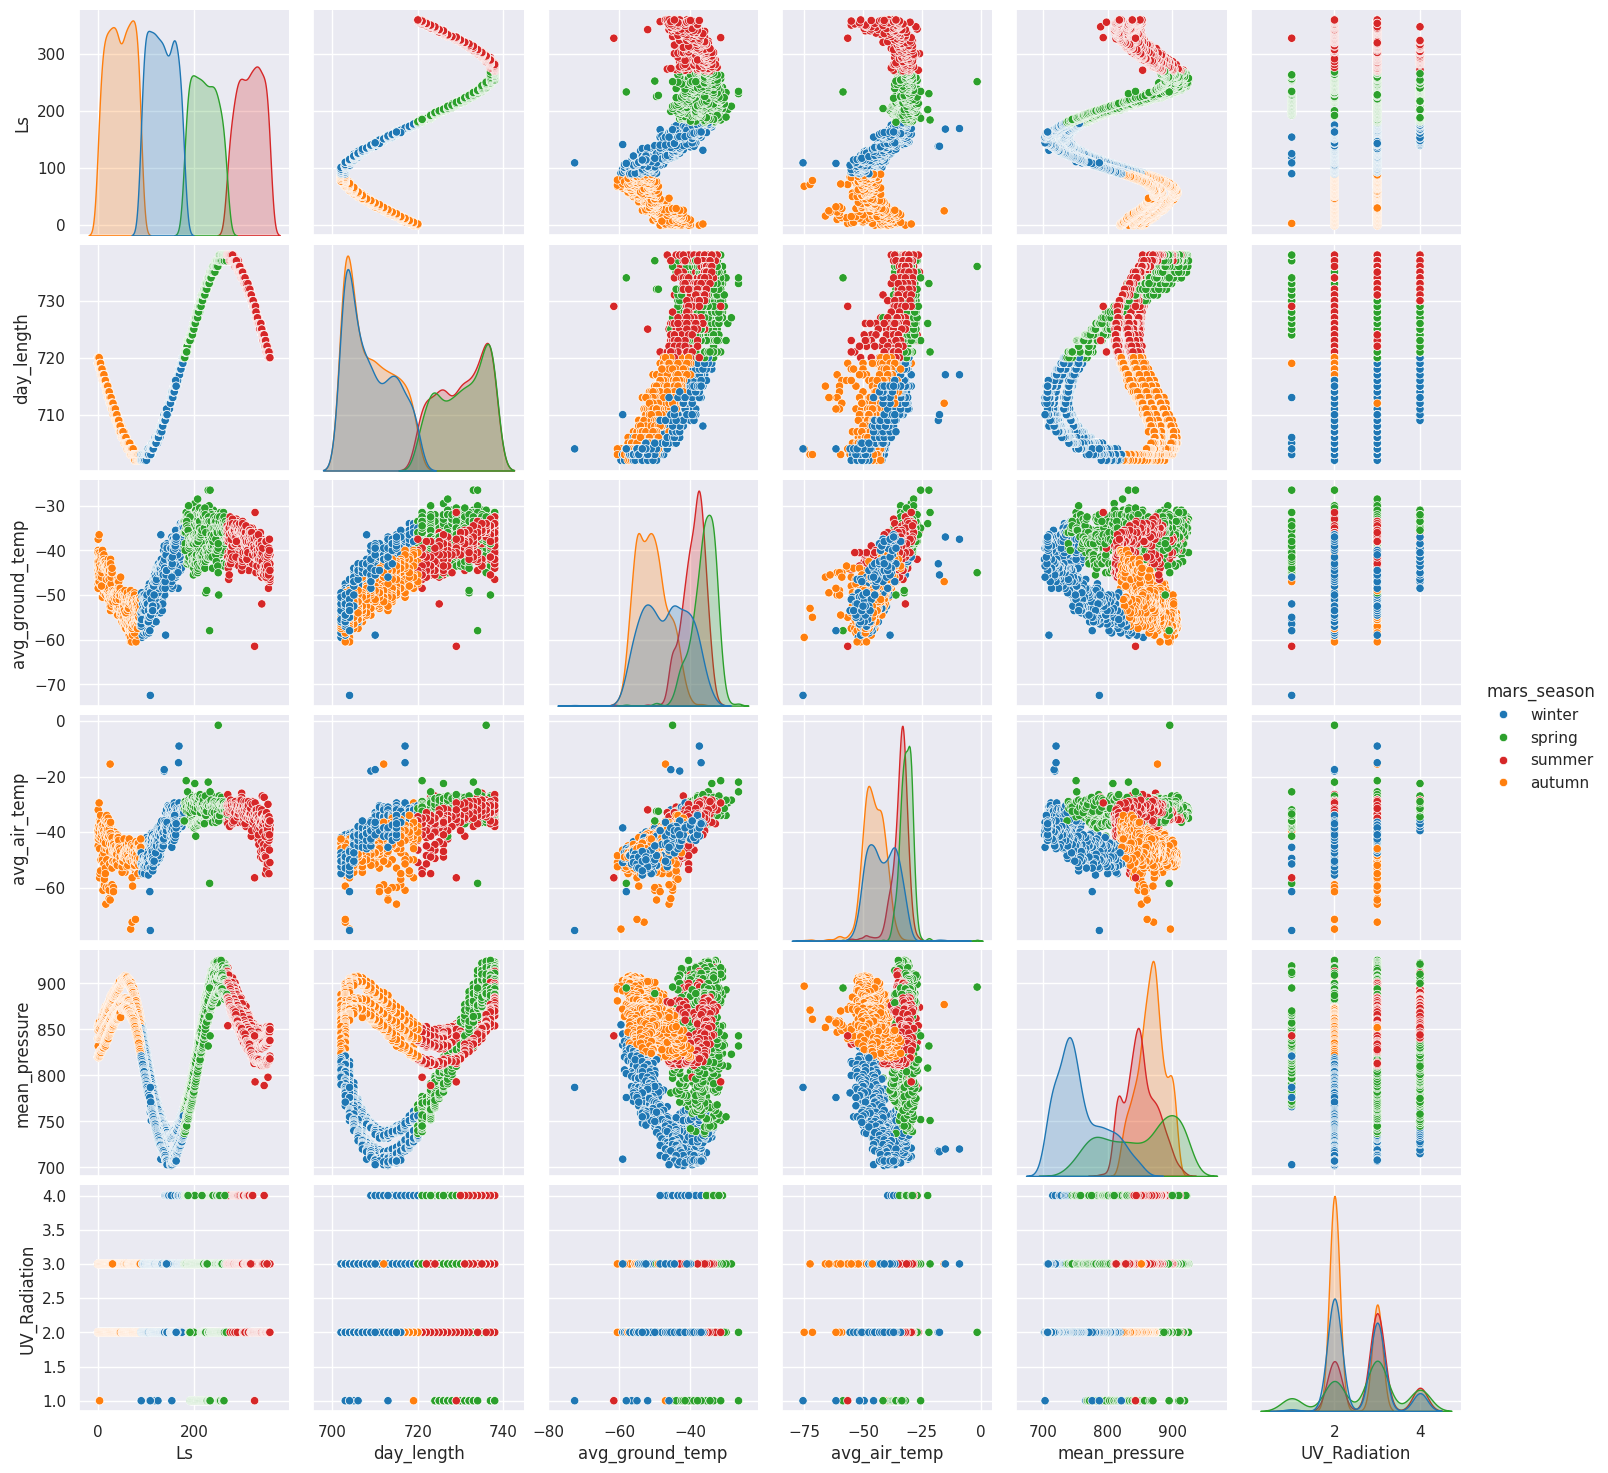

In [76]:
sns.pairplot(mars_df[features + ['mars_season']], hue='mars_season', palette=season_palette, diag_kind='kde')

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Pairplot.png'))
plt.show()

Mean pressure exhibits some pretty interesting structure and seasonality in its relationship with just about everything. Perhaps more correlation can be observed if the data is broken up into the different seasons.

### **7.2 Seasonal Trends**

#### **Winter**

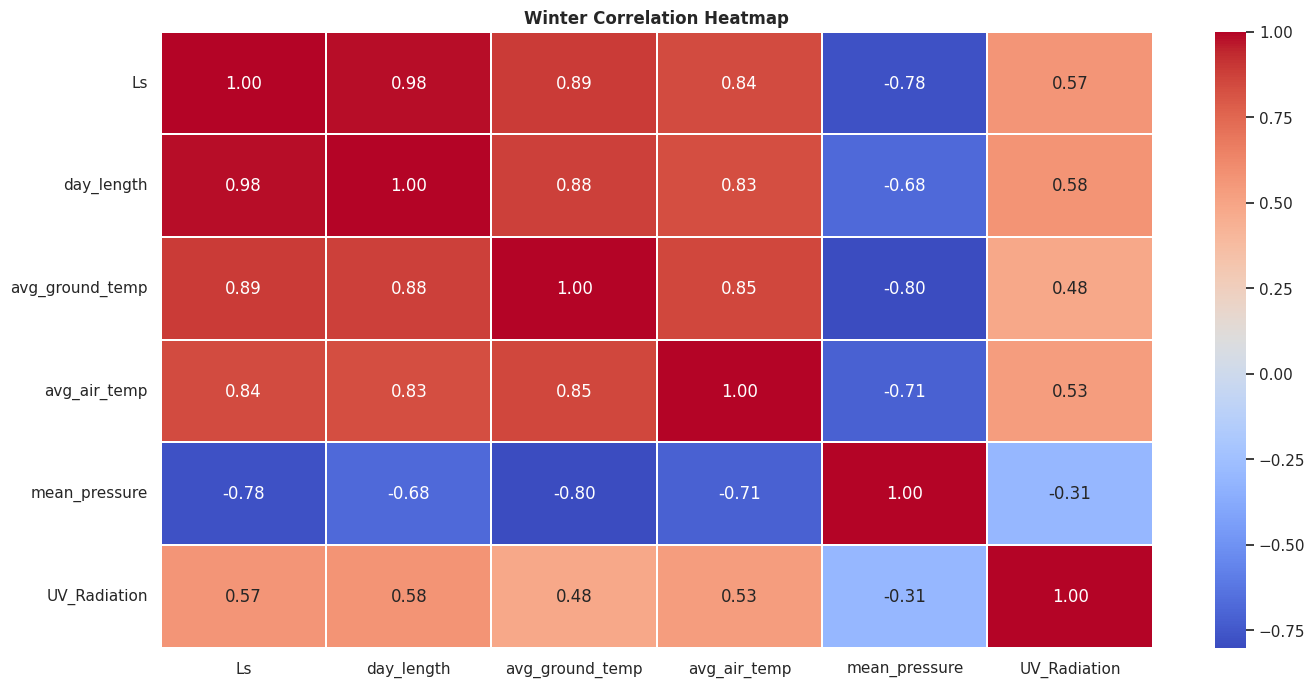

In [77]:
corr_winter = mars_df[mars_df['mars_season'] == 'winter'][features].corr()
sns.heatmap(corr_winter, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.05)
plt.title('Winter Correlation Heatmap', weight='bold')

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Winter Correlation Heatmap.png'))
plt.show()

As expected, mean pressure is highly correlated with temperature. It is interesting that the correlation is different for air and ground temperatures.

#### **Spring**

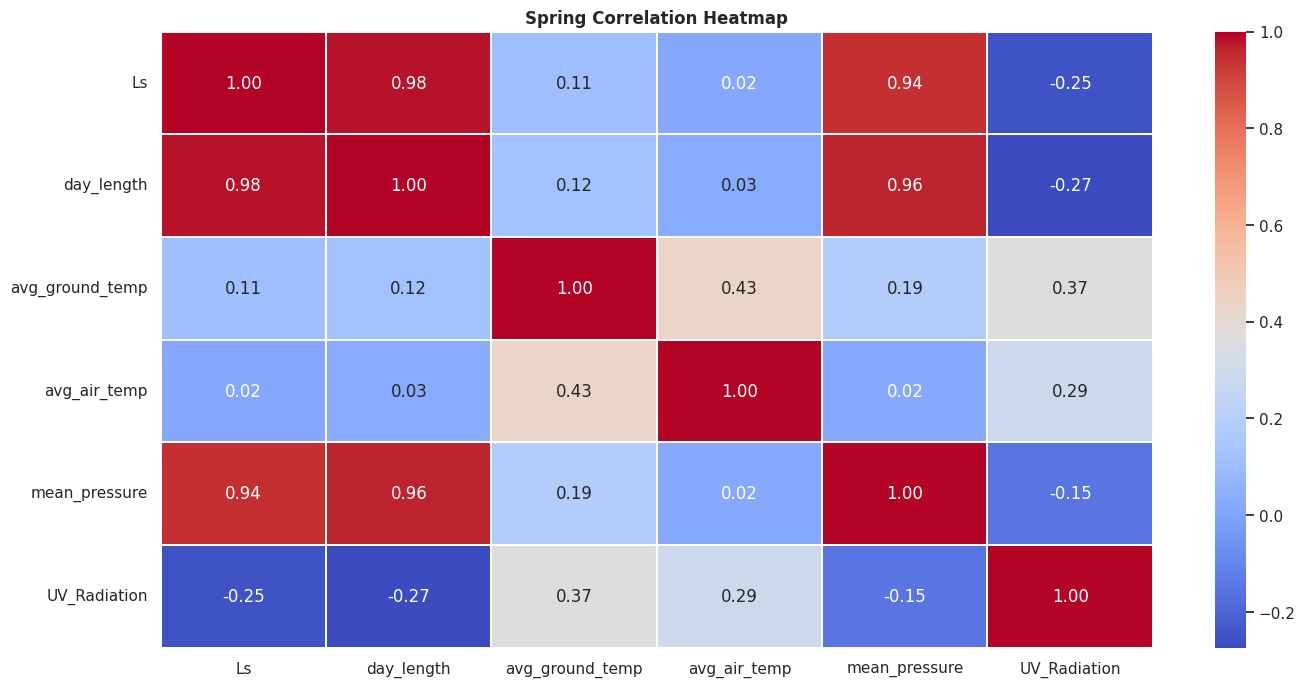

In [78]:
corr_spring = mars_df[mars_df['mars_season'] == 'spring'][features].corr()
sns.heatmap(corr_spring, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.05)
plt.title('Spring Correlation Heatmap', weight='bold')

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Spring Correlation Heatmap.png'))
plt.show()

#### **Summer**

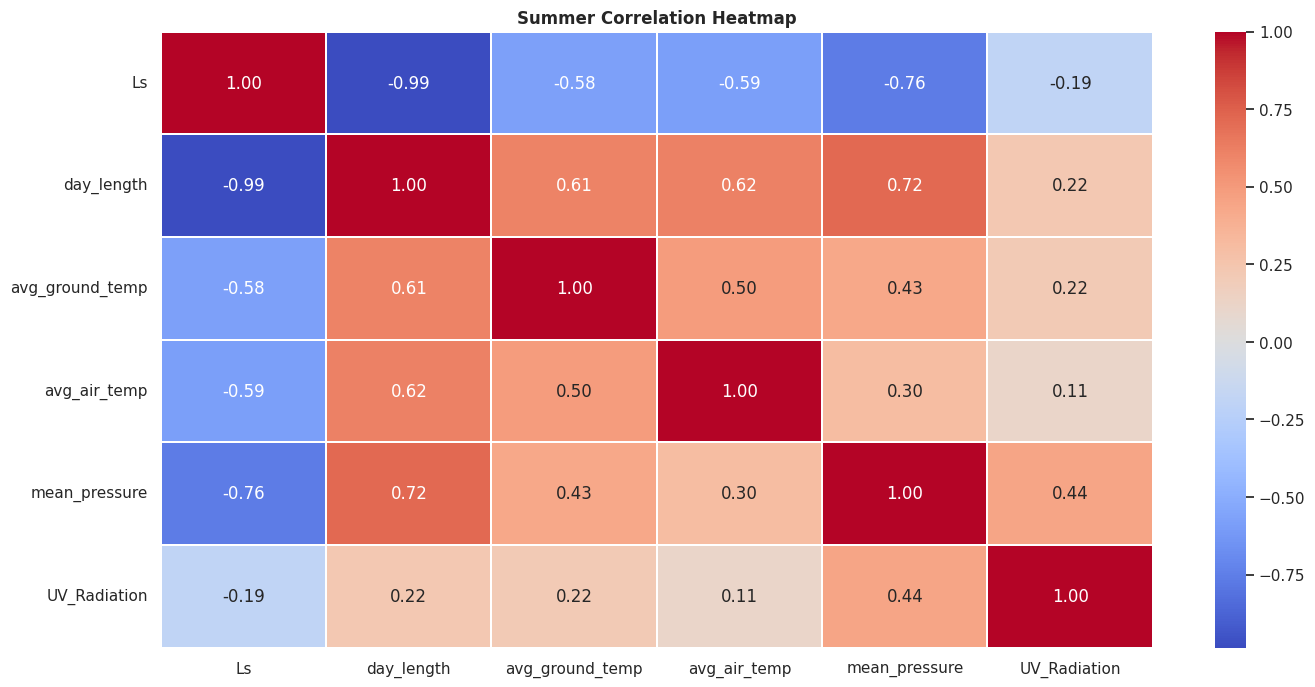

In [79]:
corr_summer = mars_df[mars_df['mars_season'] == 'summer'][features].corr()
sns.heatmap(corr_summer, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.05)
plt.title('Summer Correlation Heatmap', weight='bold')

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Summer Correlation Heatmap.png'))
plt.show()

#### **Autumn**

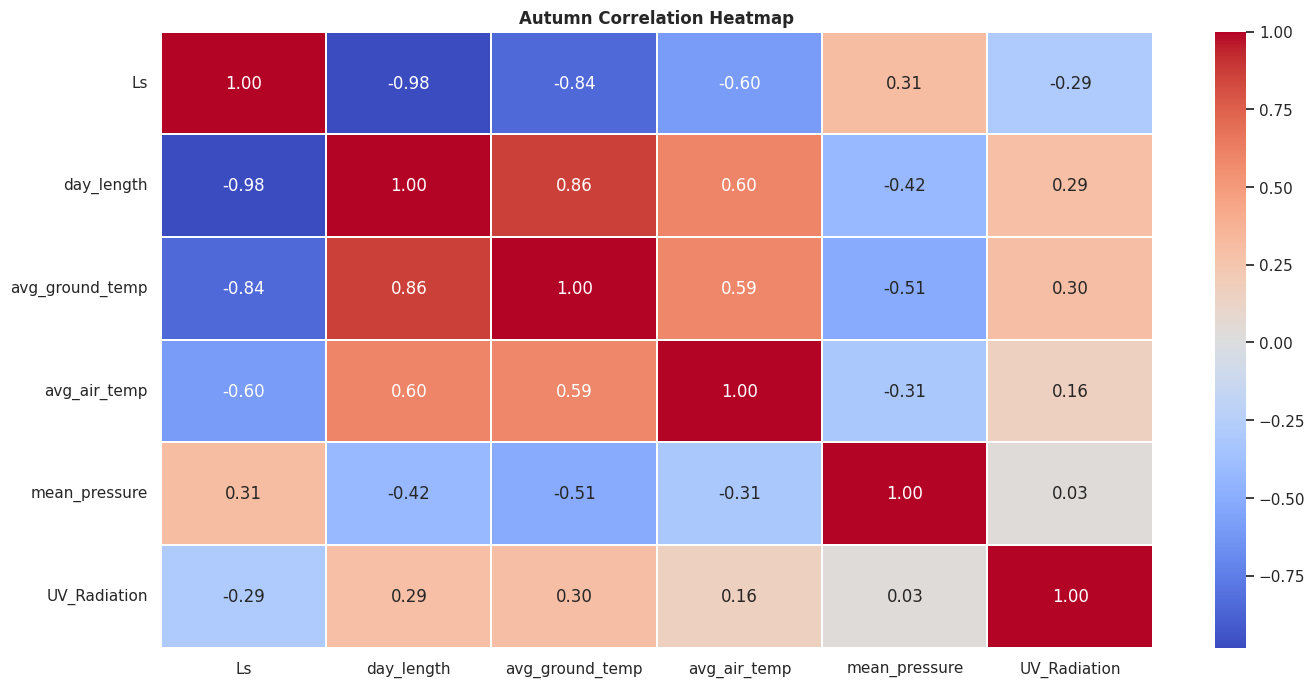

In [80]:
corr_autumn = mars_df[mars_df['mars_season'] == 'autumn'][features].corr()
sns.heatmap(corr_autumn, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.05)
plt.title('Autumn Correlation Heatmap', weight='bold')

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Autumn Correlation Heatmap.png'))
plt.show()

Pressure appears most correlated with average temperatures during summer and winter months. This is supported by the autocorrelation analysis for pressure which indicates a bimodal seasonal trend. Interestingly, during winter pressure is negatively correlated while in summer it is positive. This could be due to ice cap sublimation and condensation during those times of year.  

### **7.3 Air Temperature Vs. Ground Temperature**
Hypothesis: Ground temperature has lower variance and fewer extreme fluctuations than air temperature.

In [81]:
stat, p = levene(mars_df['avg_ground_temp'], mars_df['avg_air_temp'])
print(f"Levene test p-value: {p}")

if p < 0.05:
    print("Variances are significantly different.")
else:
    print("No significant difference in variance.")

Levene test p-value: 0.02660898310716404
Variances are significantly different.


In [82]:
def count_outliers(series):
    q1, q3 = np.percentile(series, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return ((series < lower_bound) | (series > upper_bound)).sum()

air_outliers = count_outliers(mars_df['avg_air_temp'])
ground_outliers = count_outliers(mars_df['avg_ground_temp'])

print(f"Air Temp Outliers: {air_outliers}")
print(f"Ground Temp Outliers: {ground_outliers}")

Air Temp Outliers: 8
Ground Temp Outliers: 1


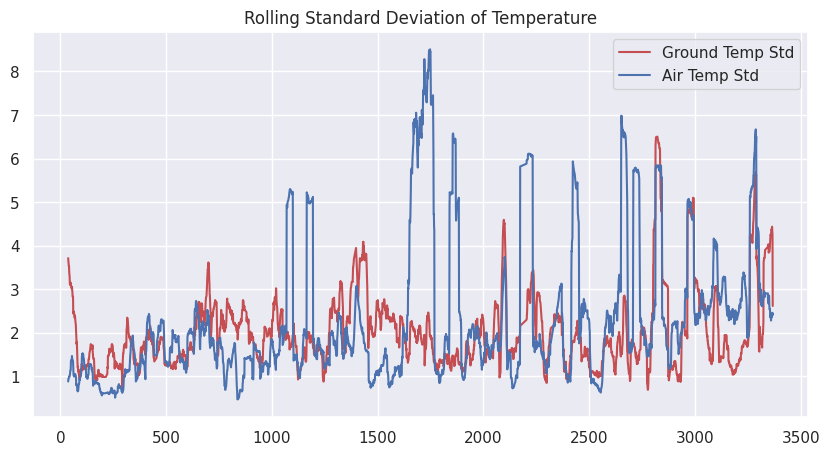

In [83]:
mars_df['ground_std'] = mars_df['avg_ground_temp'].rolling(window=30).std()
mars_df['air_std'] = mars_df['avg_air_temp'].rolling(window=30).std()

plt.figure(figsize=(10,5))
plt.plot(mars_df['ground_std'], label='Ground Temp Std', color='r')
plt.plot(mars_df['air_std'], label='Air Temp Std', color='b')
plt.legend()
plt.title("Rolling Standard Deviation of Temperature")

# Save and show plot
plt.savefig(os.path.join(PLOT_PATH, '02 - Rolling Standard Deviation of Temperature.png'))
plt.show()

Instances where the standard deviation for the air temperature shifts dramatically without a corresponding shift for the ground temperature indicates there may be some sort of weather event happening in the region. Something which may be interesting to investigate is where the air and ground temperature standard deviations spike in similar fashions at the same time.

---

### **7.4 Temperature and Pressure**

Hypothesis: There is a significant relationship between mean atmospheric pressure and mean temperature on Mars.

In [84]:
print('GROUND TEMPERATURE')
# Pearson correlation
pearson_corr, pearson_p = pearsonr(mars_df['mean_pressure'], mars_df['avg_ground_temp'])
print(f"Pearson correlation: {pearson_corr}, p-value: {pearson_p}")

# Spearman correlation
spearman_corr, spearman_p = spearmanr(mars_df['mean_pressure'], mars_df['avg_ground_temp'])
print(f"Spearman correlation: {spearman_corr}, p-value: {spearman_p}")

# Kendall correlation
kendall_corr, kendall_p = kendalltau(mars_df['mean_pressure'], mars_df['avg_ground_temp'])
print(f"Kendall correlation: {kendall_corr}, p-value: {kendall_p}")
print('------------------')
print('AIR TEMPERATURE')
# Pearson correlation
pearson_corr, pearson_p = pearsonr(mars_df['mean_pressure'], mars_df['avg_air_temp'])
print(f"Pearson correlation: {pearson_corr}, p-value: {pearson_p}")

# Spearman correlation
spearman_corr, spearman_p = spearmanr(mars_df['mean_pressure'], mars_df['avg_air_temp'])
print(f"Spearman correlation: {spearman_corr}, p-value: {spearman_p}")

# Kendall correlation
kendall_corr, kendall_p = kendalltau(mars_df['mean_pressure'], mars_df['avg_air_temp'])
print(f"Kendall correlation: {kendall_corr}, p-value: {kendall_p}")

GROUND TEMPERATURE
Pearson correlation: -0.041346031490376495, p-value: 0.019393807167532116
Spearman correlation: 0.0006147133108251812, p-value: 0.9722842393643044
Kendall correlation: -0.009964458563004755, p-value: 0.4041970620435652
------------------
AIR TEMPERATURE
Pearson correlation: -0.03813493432324095, p-value: 0.03107060704616
Spearman correlation: 0.00833675035943463, p-value: 0.6374975232393542
Kendall correlation: -0.0018206259189685746, p-value: 0.8789908098592158


These results indicate that there is no direct correlation between pressure and temperature when tests are applied to the entire dataset. This reflects what was observed in the first heatmap from earlier. It will be necessary to test on a season by season basis.

In [85]:
# Get unique seasons
seasons = mars_df['mars_season'].unique()

for season in seasons:
    season_df = mars_df[mars_df['mars_season'] == season]  # Filter for the current season
    print(f"===== SEASON: {season} =====")

    print('GROUND TEMPERATURE')
    if len(season_df) > 1:  # Ensure there's enough data to compute correlation
        # Pearson correlation
        pearson_corr, pearson_p = pearsonr(season_df['mean_pressure'], season_df['avg_ground_temp'])
        print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

        # Spearman correlation
        spearman_corr, spearman_p = spearmanr(season_df['mean_pressure'], season_df['avg_ground_temp'])
        print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

        # Kendall correlation
        kendall_corr, kendall_p = kendalltau(season_df['mean_pressure'], season_df['avg_ground_temp'])
        print(f"Kendall correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")
    else:
        print("Not enough data for correlation analysis.")

    print('------------------')

    print('AIR TEMPERATURE')
    if len(season_df) > 1:
        # Pearson correlation
        pearson_corr, pearson_p = pearsonr(season_df['mean_pressure'], season_df['avg_air_temp'])
        print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

        # Spearman correlation
        spearman_corr, spearman_p = spearmanr(season_df['mean_pressure'], season_df['avg_air_temp'])
        print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

        # Kendall correlation
        kendall_corr, kendall_p = kendalltau(season_df['mean_pressure'], season_df['avg_air_temp'])
        print(f"Kendall correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")
    else:
        print("Not enough data for correlation analysis.")

    print("\n" + "="*30 + "\n")


===== SEASON: winter =====
GROUND TEMPERATURE
Pearson correlation: -0.8007, p-value: 0.0000
Spearman correlation: -0.7968, p-value: 0.0000
Kendall correlation: -0.6142, p-value: 0.0000
------------------
AIR TEMPERATURE
Pearson correlation: -0.7106, p-value: 0.0000
Spearman correlation: -0.7444, p-value: 0.0000
Kendall correlation: -0.5351, p-value: 0.0000


===== SEASON: spring =====
GROUND TEMPERATURE
Pearson correlation: 0.1878, p-value: 0.0000
Spearman correlation: 0.2293, p-value: 0.0000
Kendall correlation: 0.1542, p-value: 0.0000
------------------
AIR TEMPERATURE
Pearson correlation: 0.0228, p-value: 0.5549
Spearman correlation: -0.0407, p-value: 0.2921
Kendall correlation: -0.0377, p-value: 0.1571


===== SEASON: summer =====
GROUND TEMPERATURE
Pearson correlation: 0.4295, p-value: 0.0000
Spearman correlation: 0.4847, p-value: 0.0000
Kendall correlation: 0.3344, p-value: 0.0000
------------------
AIR TEMPERATURE
Pearson correlation: 0.3046, p-value: 0.0000
Spearman correlation

Pressure and temperature are extremely strongly correlated in the winter. The rest of the seasons are rather muted in comparison which suggests cooling may have a stronger effect on pressure than warming.

In [86]:
data = mars_df[['avg_ground_temp', 'mean_pressure']]
max_lags = 6
results = grangercausalitytests(data, max_lags, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6495  , p=0.1991  , df_denom=3193, df_num=1
ssr based chi2 test:   chi2=1.6510  , p=0.1988  , df=1
likelihood ratio test: chi2=1.6506  , p=0.1989  , df=1
parameter F test:         F=1.6495  , p=0.1991  , df_denom=3193, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9154  , p=0.0543  , df_denom=3190, df_num=2
ssr based chi2 test:   chi2=5.8399  , p=0.0539  , df=2
likelihood ratio test: chi2=5.8346  , p=0.0541  , df=2
parameter F test:         F=2.9154  , p=0.0543  , df_denom=3190, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.6769  , p=0.0007  , df_denom=3187, df_num=3
ssr based chi2 test:   chi2=17.0681 , p=0.0007  , df=3
likelihood ratio test: chi2=17.0227 , p=0.0007  , df=3
parameter F test:         F=5.6769  , p=0.0007  , df_denom=3187, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=8.7913  , p=0.

From the results of the Granger Causality test, it appears that ground temperature does have an effect on pressure, but with a several days of lag.

In [87]:
def plot_3d(mars_df, x_col, y_col, z_col, season_col, season_palette, interactive=False):
    """
    Plots a 3D scatter plot of three selected features from a given DataFrame, colored by season.
    
    Parameters:
    mars_df (pd.DataFrame): The input DataFrame.
    x_col (str): Column name for the x-axis.
    y_col (str): Column name for the y-axis.
    z_col (str): Column name for the z-axis.
    season_col (str): Column name for the season category.
    season_palette (dict): Dictionary mapping season names to colors.
    interactive (bool): If True, use Plotly for an interactive plot; otherwise, use Matplotlib.
    """
    
    if interactive:
        fig = px.scatter_3d(mars_df, x=x_col, y=y_col, z=z_col, color=mars_df[season_col].map(season_palette), 
                            title=f'3D Scatter Plot of {x_col}, {y_col}, {z_col} by Season')
        fig.update_layout(scene=dict(
            xaxis_title=x_col,
            yaxis_title=y_col,
            zaxis_title=z_col
        ))
        
        fig.show()
    else:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        
        for season, color in season_palette.items():
            subset = mars_df[mars_df[season_col] == season]
            ax.scatter(subset[x_col], subset[y_col], subset[z_col], c=color, label=season, alpha=0.7)
        
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_zlabel(z_col)
        ax.set_title(f'3D Scatter Plot of {x_col}, {y_col}, {z_col} by Season')
        ax.legend()
        
        # Save and show plot
        plt.savefig(os.path.join(PLOT_PATH, f'02 - 3D Scatter Plot of {x_col}, {y_col}, {z_col} by Season'))
        plt.show()

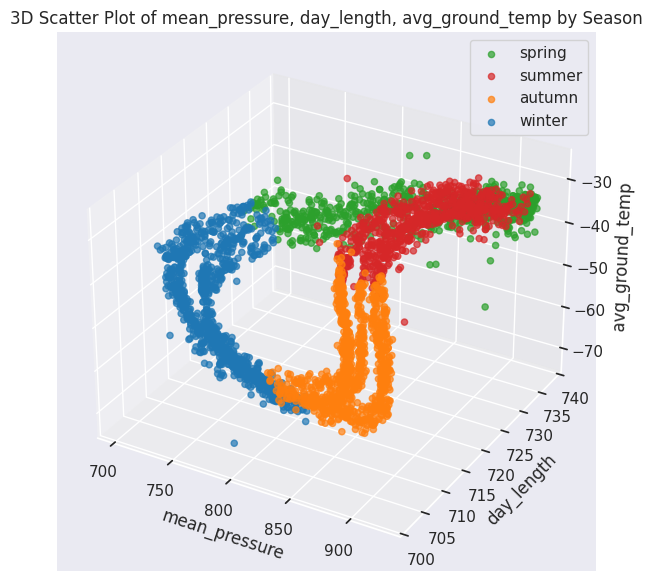

In [88]:
plot_3d(mars_df, 'mean_pressure', 'day_length', 'avg_ground_temp', 'mars_season', season_palette)

In [89]:
# ANOVA: Check if temp/pressure means differ across UV categories
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA for temperature
model_temp = ols('avg_ground_temp ~ C(UV_Radiation)', data=mars_df).fit()
anova_temp = sm.stats.anova_lm(model_temp, typ=2)

# ANOVA for pressure
model_pressure = ols('mean_pressure ~ C(UV_Radiation)', data=mars_df).fit()
anova_pressure = sm.stats.anova_lm(model_pressure, typ=2)

print("ANOVA Results for Temperature & UV Radiation:\n", anova_temp)
print("\nANOVA Results for Pressure & UV Radiation:\n", anova_pressure)


ANOVA Results for Temperature & UV Radiation:
                         sum_sq      df           F         PR(>F)
C(UV_Radiation)   35533.548907     3.0  270.994995  1.087701e-156
Residual         139558.077418  3193.0         NaN            NaN

ANOVA Results for Pressure & UV Radiation:
                        sum_sq      df         F    PR(>F)
C(UV_Radiation)  6.987177e+04     3.0  7.153531  0.000087
Residual         1.039583e+07  3193.0       NaN       NaN


In [90]:
# Kruskal-Wallis test (non-parametric ANOVA alternative)
kruskal_temp = stats.kruskal(
    mars_df[mars_df['UV_Radiation'] == 1]['avg_ground_temp'],
    mars_df[mars_df['UV_Radiation'] == 2]['avg_ground_temp'],
    mars_df[mars_df['UV_Radiation'] == 3]['avg_ground_temp'],
    mars_df[mars_df['UV_Radiation'] == 4]['avg_ground_temp']
)

kruskal_pressure = stats.kruskal(
    mars_df[mars_df['UV_Radiation'] == 1]['mean_pressure'],
    mars_df[mars_df['UV_Radiation'] == 2]['mean_pressure'],
    mars_df[mars_df['UV_Radiation'] == 3]['mean_pressure'],
    mars_df[mars_df['UV_Radiation'] == 4]['mean_pressure']
)

print("\nKruskal-Wallis Results:")
print(f"Temperature & UV: H={kruskal_temp.statistic}, p={kruskal_temp.pvalue}")
print(f"Pressure & UV: H={kruskal_pressure.statistic}, p={kruskal_pressure.pvalue}")


Kruskal-Wallis Results:
Temperature & UV: H=640.1031257361294, p=2.0375780351954966e-138
Pressure & UV: H=21.585336605453637, p=7.956117439052357e-05
